In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [2]:
atlas_name = 'atlasV5'

In [3]:
fp = DataManager.get_instance_centroids_filepath(atlas_name=atlas_name)
download_from_s3(fp)
instance_centroids_rel2fixed = load_pickle(fp)

In [4]:
ann_vol_bbox_rel2uncropped = DataManager.load_original_volume_bbox(stack='MD589', volume_type='annotation', downscale=32)
print 'annotation volume bbox (rel2uncropped):', ann_vol_bbox_rel2uncropped

annotation volume bbox (rel2uncropped): [ 622 1042  155  502  128  503]


In [5]:
canonical_locations_rel2canon, canonical_centroid_rel2fixed, canonical_normal = \
average_location(instance_centroids_rel2fixed)

canonical_centroid_rel2uncropped = canonical_centroid_rel2fixed + ann_vol_bbox_rel2uncropped[[0,2,4]]
print 'canonical_centroid_rel2uncropped', canonical_centroid_rel2uncropped

[ 0.04111027 -0.09160432  0.99494653] @ [ 172.0630378   223.21016434  186.74030921]
canonical_centroid_rel2uncropped [ 794.0630378   378.21016434  314.74030921]


In [34]:
canonical_locations_rel2fixed = {k: canonical_centroid_rel2fixed + c_rel2canon 
                                 for k, c_rel2canon in canonical_locations_rel2canon.iteritems()}

In [7]:
print 'deviation angle:', np.rad2deg(np.arccos(canonical_normal[2]))

deviation angle: 5.76256199381


In [8]:
canonical_midplane_xx, canonical_midplane_yy = np.meshgrid(range(0, 500, 100), range(0, 500, 100), indexing='xy')
canonical_midplane_z = -(canonical_normal[0]*(canonical_midplane_xx-canonical_centroid_rel2fixed[0]) + \
canonical_normal[1]*(canonical_midplane_yy-canonical_centroid_rel2fixed[1]) + \
canonical_normal[2]*(-canonical_centroid_rel2fixed[2]))/canonical_normal[2]

In [12]:
radii_allStructures = {}
ellipsoid_matrix_allStructures = {}
for name_s, centroids in sorted(instance_centroids_rel2fixed.items()):
    centroids2 = np.array(centroids)
    cov_mat = np.cov(centroids2.T)
    u, s, vt = np.linalg.svd(cov_mat)
#     print name_s, u[:,0], u[:,1], u[:,2],
    radii_allStructures[name_s] = np.sqrt(s)
    ellipsoid_matrix_allStructures[name_s] = vt

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


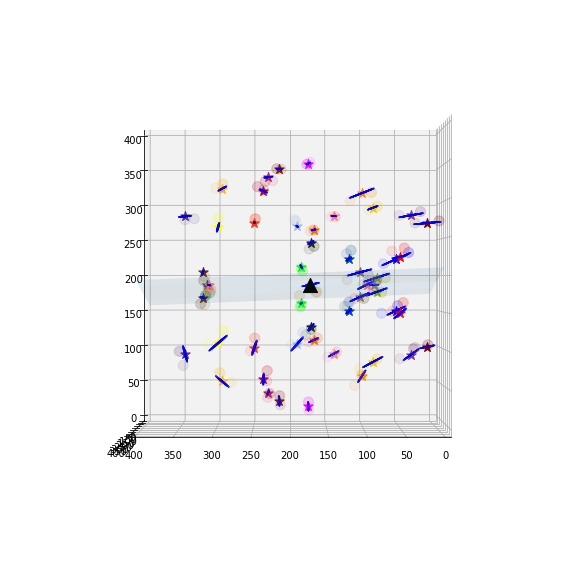

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for name_s, centroids in instance_centroids_rel2fixed.iteritems():
#     if name_s == '7N_L' or name_s == '7N_R':
    centroids2 = np.array(centroids)
    ax.scatter(centroids2[:,0], centroids2[:,1], centroids2[:,2], 
               color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
               marker='o', s=100, alpha=.1)
    
    c = canonical_locations_rel2fixed[name_s]
    ax.scatter(c[0], c[1], c[2], 
               color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., marker='*', s=100)
    
    # Plot uncerntainty ellipsoids
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    x = radii_allStructures[name_s][0] * np.outer(np.cos(u), np.sin(v))
    y = radii_allStructures[name_s][1] * np.outer(np.sin(u), np.sin(v))
    z = radii_allStructures[name_s][2] * np.outer(np.ones_like(u), np.cos(v))
    for i in range(len(u)):
        for j in range(len(v)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], ellipsoid_matrix_allStructures[name_s]) + c

#     ax.plot_surface(x, y, z, color='b')
    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
    
ax.scatter(canonical_centroid_rel2fixed[0], canonical_centroid_rel2fixed[1], canonical_centroid_rel2fixed[2], 
           color=(0,0,0), marker='^', s=200)

# Plot mid-sagittal plane
ax.plot_surface(canonical_midplane_xx, canonical_midplane_yy, canonical_midplane_z, alpha=.1)

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# ax.set_axis_off()
ax.set_xlim3d([0, 400]);
ax.set_ylim3d([0, 400]);
ax.set_zlim3d([0, 400]);
# ax.view_init(azim = 90 + 20,elev = 0 - 20)
ax.view_init(azim = 90,elev = 0)
ax.set_aspect(1.0)
plt.legend()
plt.show()

In [97]:
def consolidate(params, centroid_m, centroid_f):
    G = params.reshape((3,4))
    R = G[:3,:3]
    t = - np.dot(R, centroid_m) + G[:3,3] + centroid_f
    return np.vstack([np.c_[R,t], [0,0,0,1]])

In [108]:
adjusted_structure_centroids_rel2atlas = defaultdict(dict)

for s in all_known_structures_sided:
    print s
    try:
        c = canonical_locations_rel2fixed[s]
        for stack in all_nissl_stacks:
            global_params, centroid_m, centroid_f, _,_,_,_,_,_ = \
            DataManager.load_alignment_parameters(stack_m=atlas_name, stack_f=stack,
                                                  prep_id_f=2,
                                                  detector_id_f=15,
                                                  warp_setting=20)

            Gas = consolidate(global_params, centroid_m, centroid_f)

            local_params, centroid_m, centroid_f, _,_,_,_,_,_ = \
            DataManager.load_alignment_parameters(stack_m=atlas_name, stack_f=stack,
                                                  prep_id_f=2,
                                                  detector_id_f=15,
                                                  warp_setting=17,
                                                  structure_f=s,
                                                  structure_m=s)
            Lss = consolidate(local_params, centroid_m, centroid_f)
            
            Gas_inv = np.linalg.inv(Gas)
            Laa = np.dot(Gas_inv, np.dot(Lss, Gas))
            
            adjusted_structure_centroids_rel2atlas[s][stack] = np.dot(Laa[:3, :3], c) + Laa[:3, 3]
    except Exception as e:
        sys.stderr.write("Cannot compute centroid in atlas space for %s: %s\n" % (s, e))
        
adjusted_structure_centroids_rel2atlas.default_factory = None

5N_L
5N_R
6N_L
6N_R
7N_L
7N_R
7n_L
7n_R
Amb_L
Amb_R
LC_L
LC_R
LRt_L
LRt_R
Pn_L
Pn_R
Tz_L
Tz_R
VLL_L
VLL_R
RMC_L
RMC_R
SNC_L
SNC_R
SNR_L
SNR_R
3N_L
3N_R
4N_L
4N_R
Sp5I_L
Sp5I_R
Sp5O_L
Sp5O_R
Sp5C_L
Sp5C_R
PBG_L
PBG_R
10N_L
10N_R
VCA_L
VCA_R
VCP_L
VCP_R
DC_L
DC_R
AP
12N
RtTg
SC
rm -rf "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC_parameters.txt" && mkdir -p "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC"
aws s3 cp "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC_parameters.txt" "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_

File does not exist: /shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC_parameters.txt
Cannot compute centroid in atlas space for SC: [Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC/atlasV5_down32_scoreVolume_SC_warp17_MD599_prep2_detector15_down32_scoreVolume_SC_parameters.txt'


IC


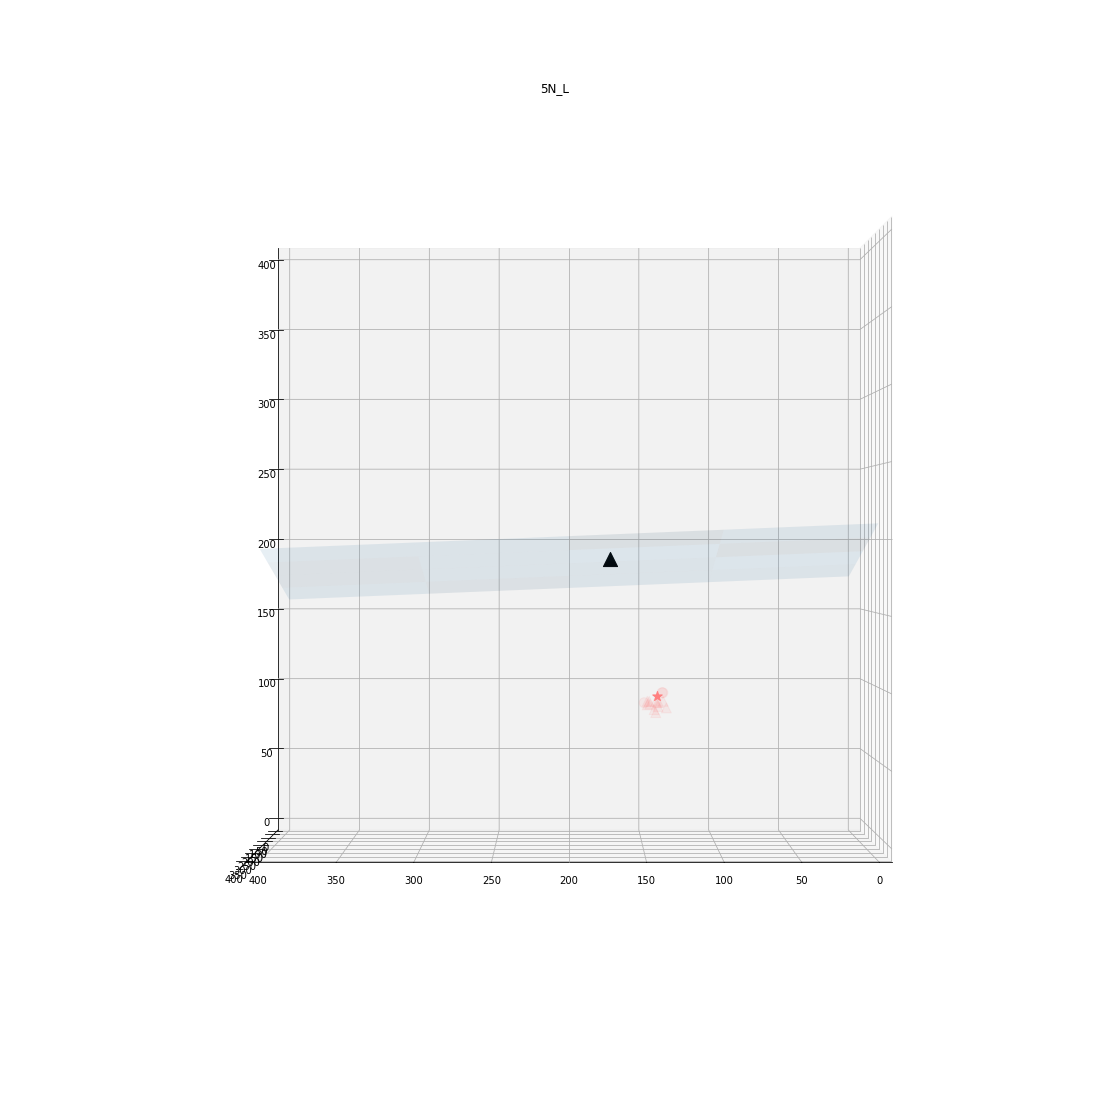

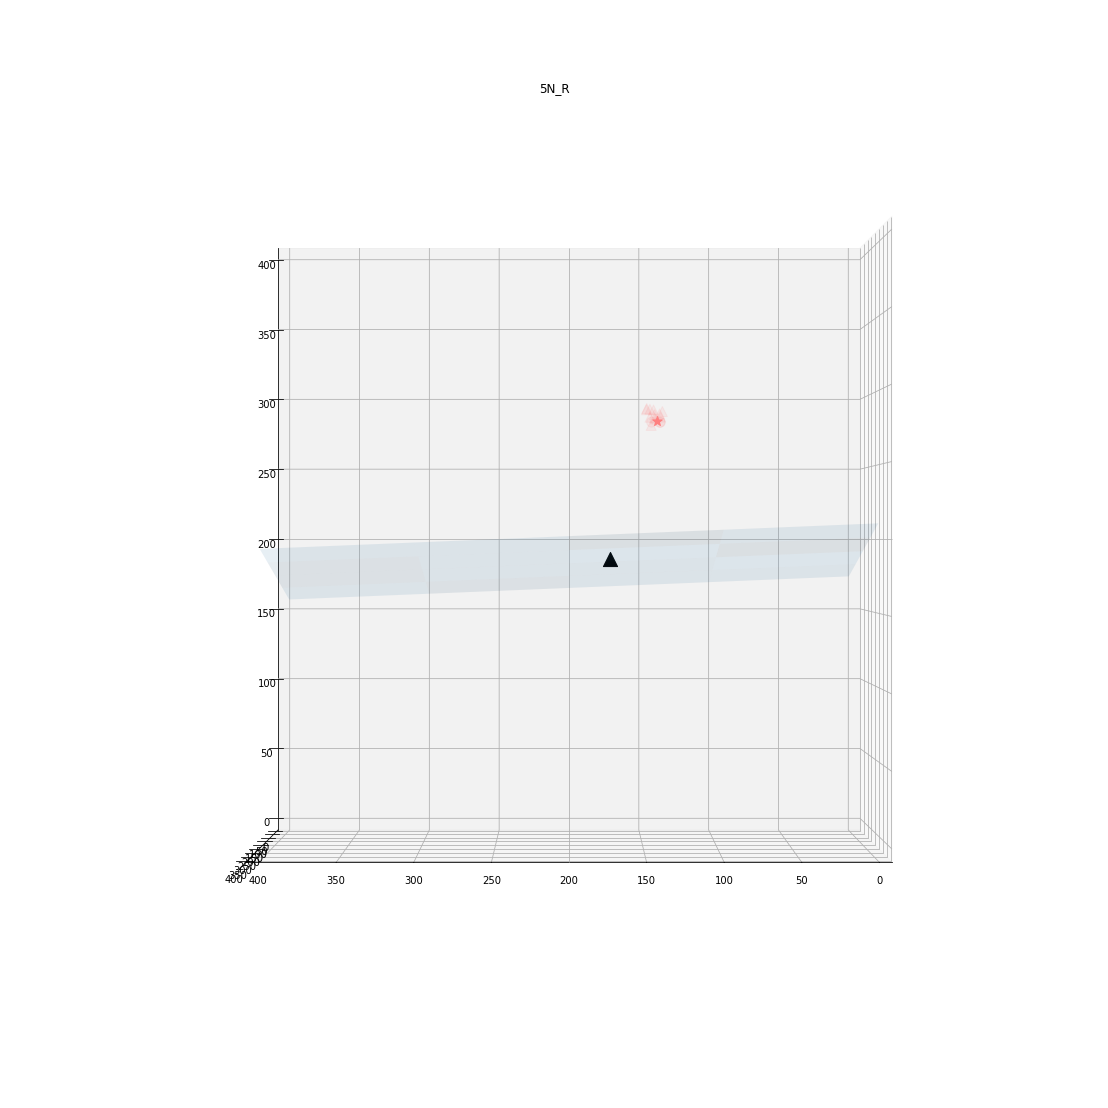

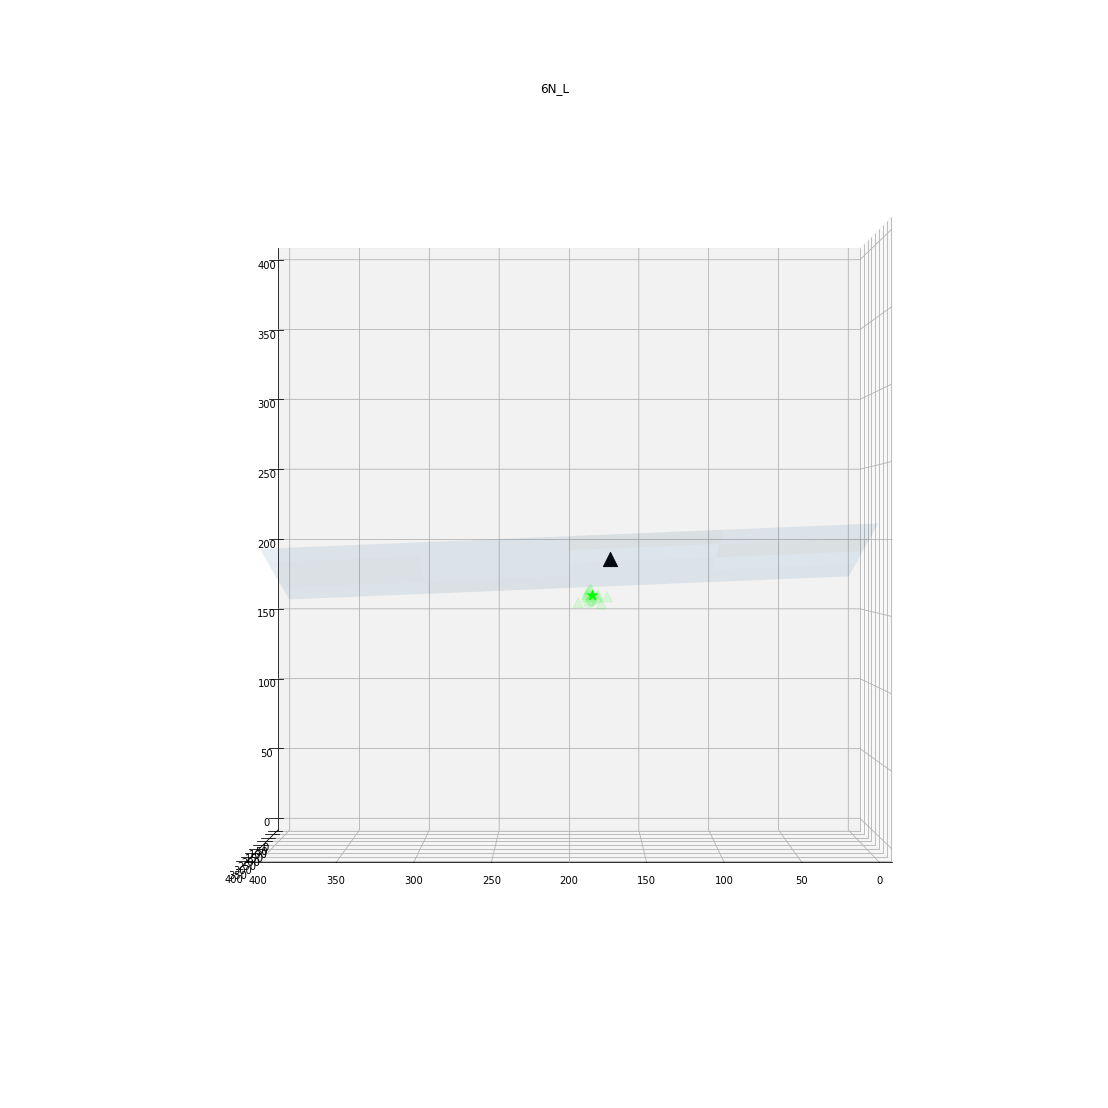

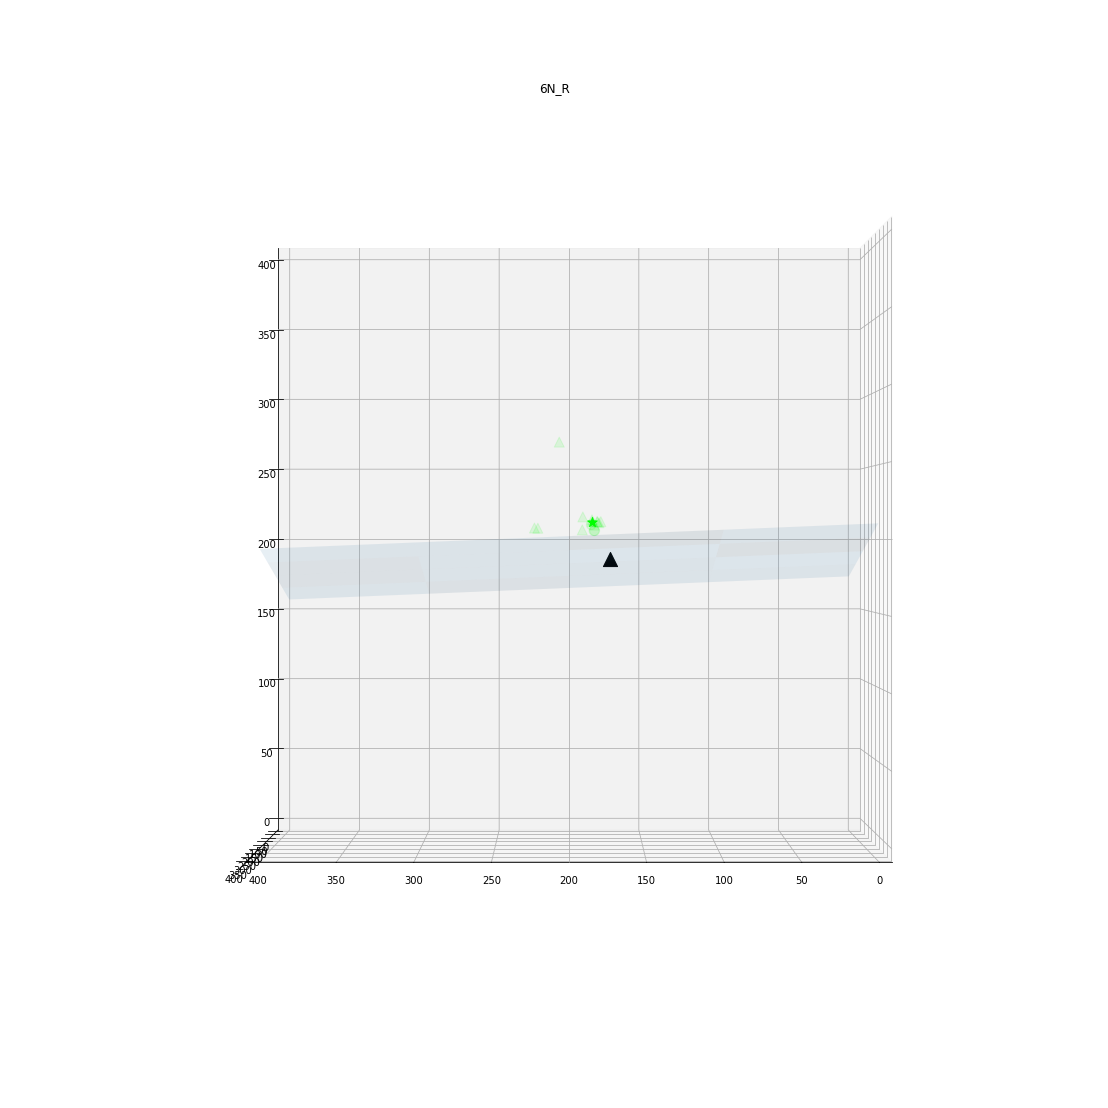

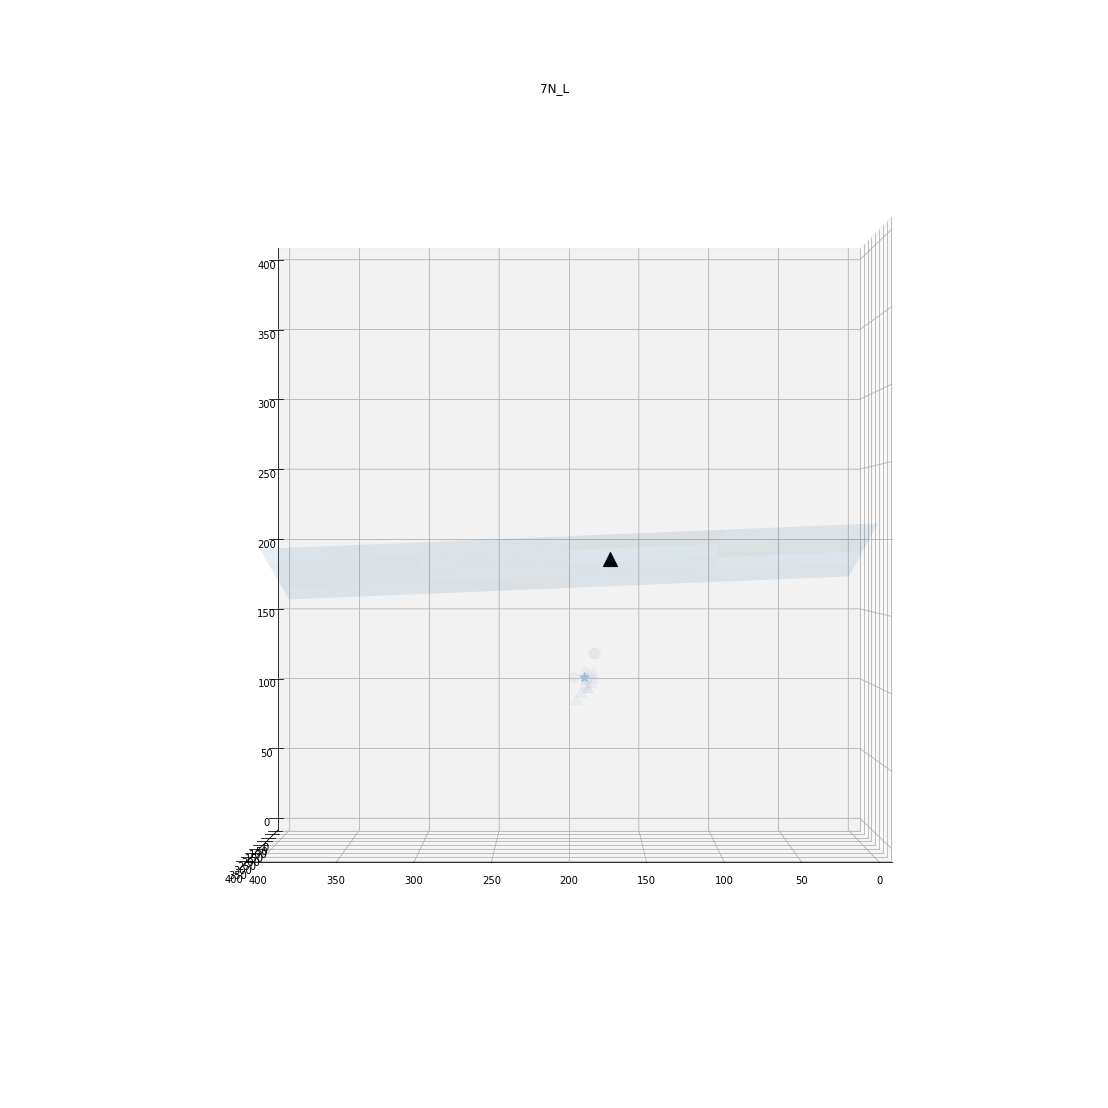

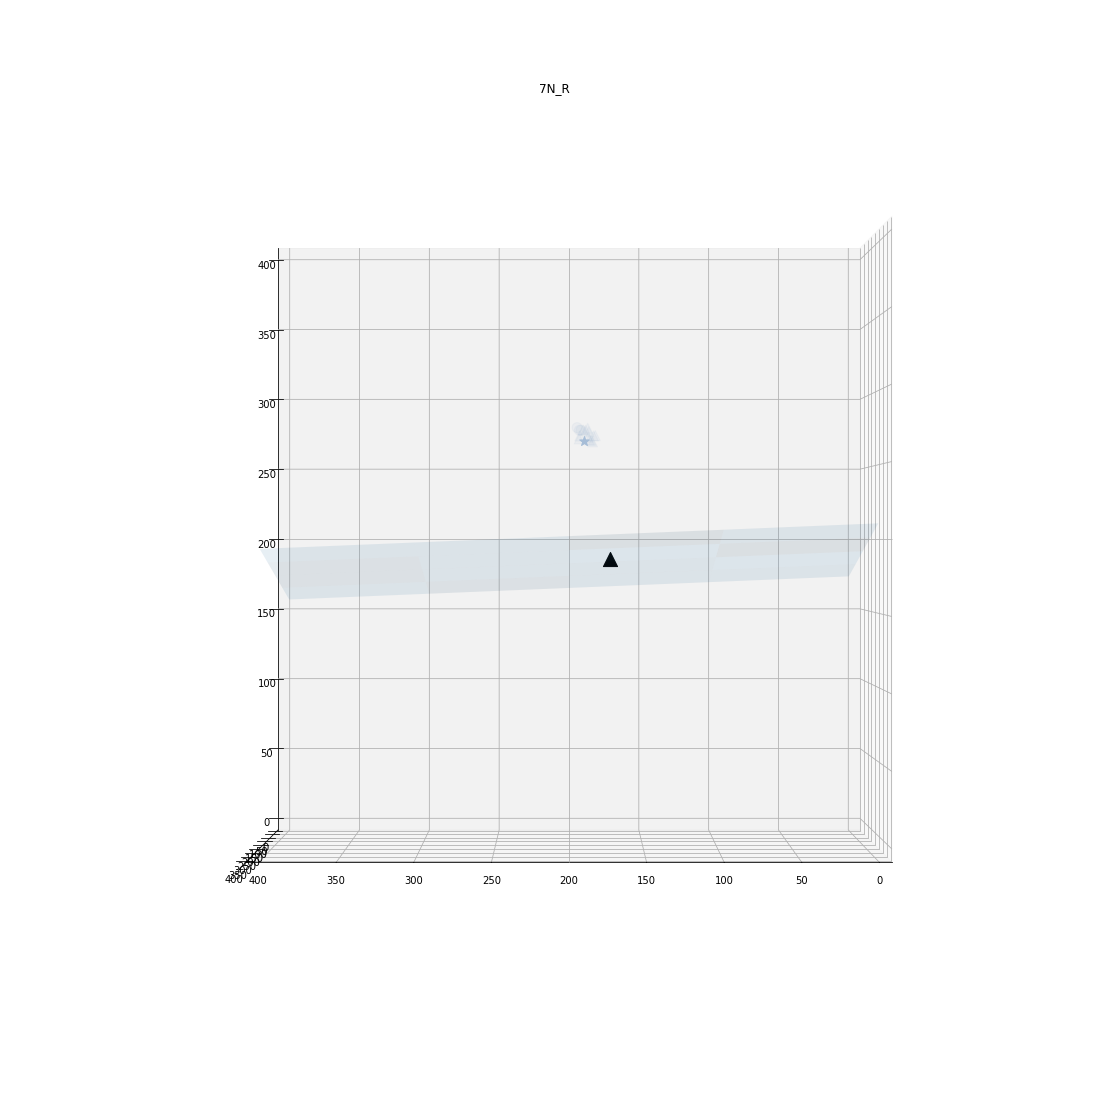

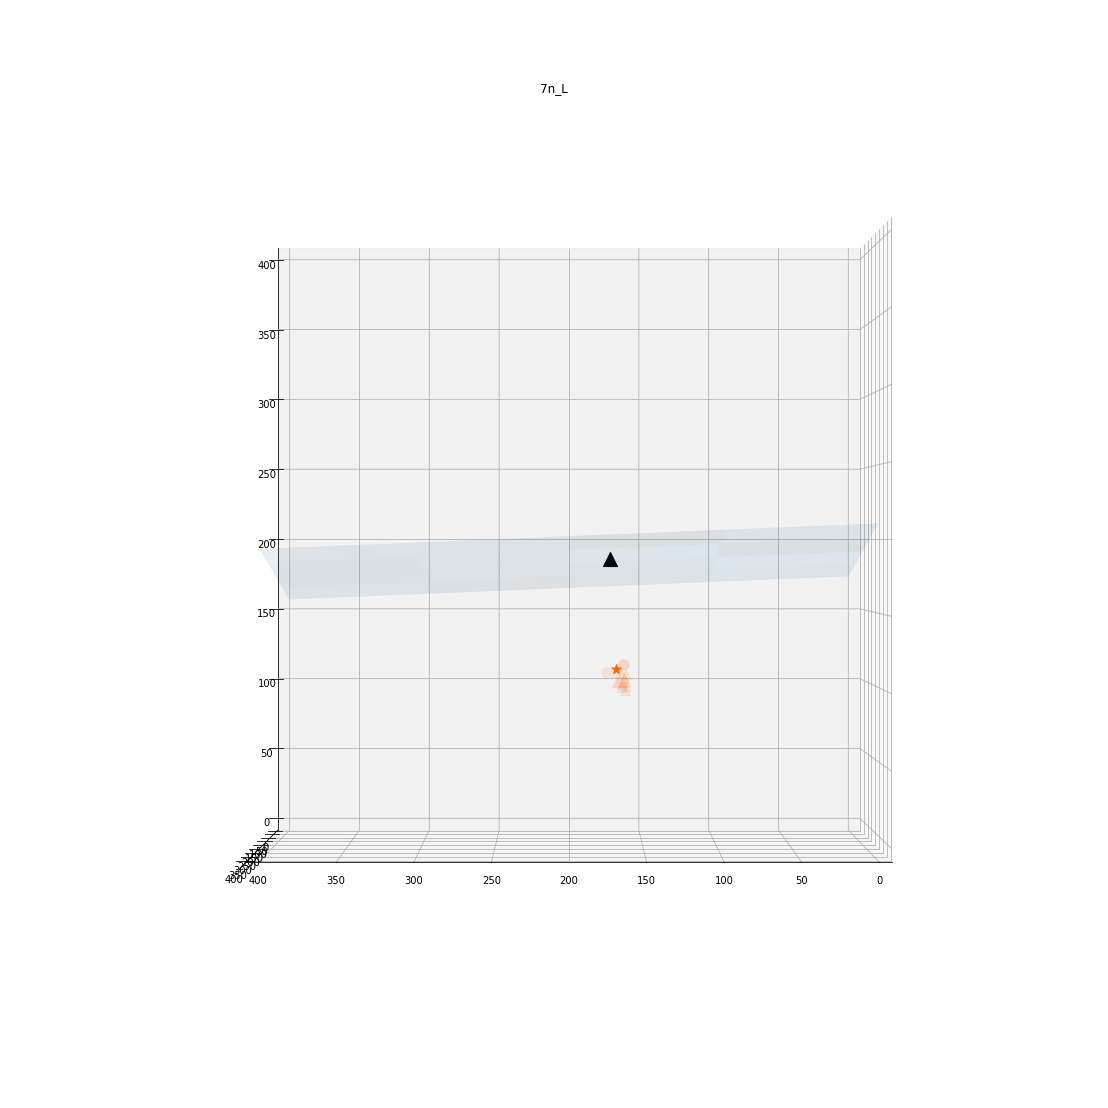

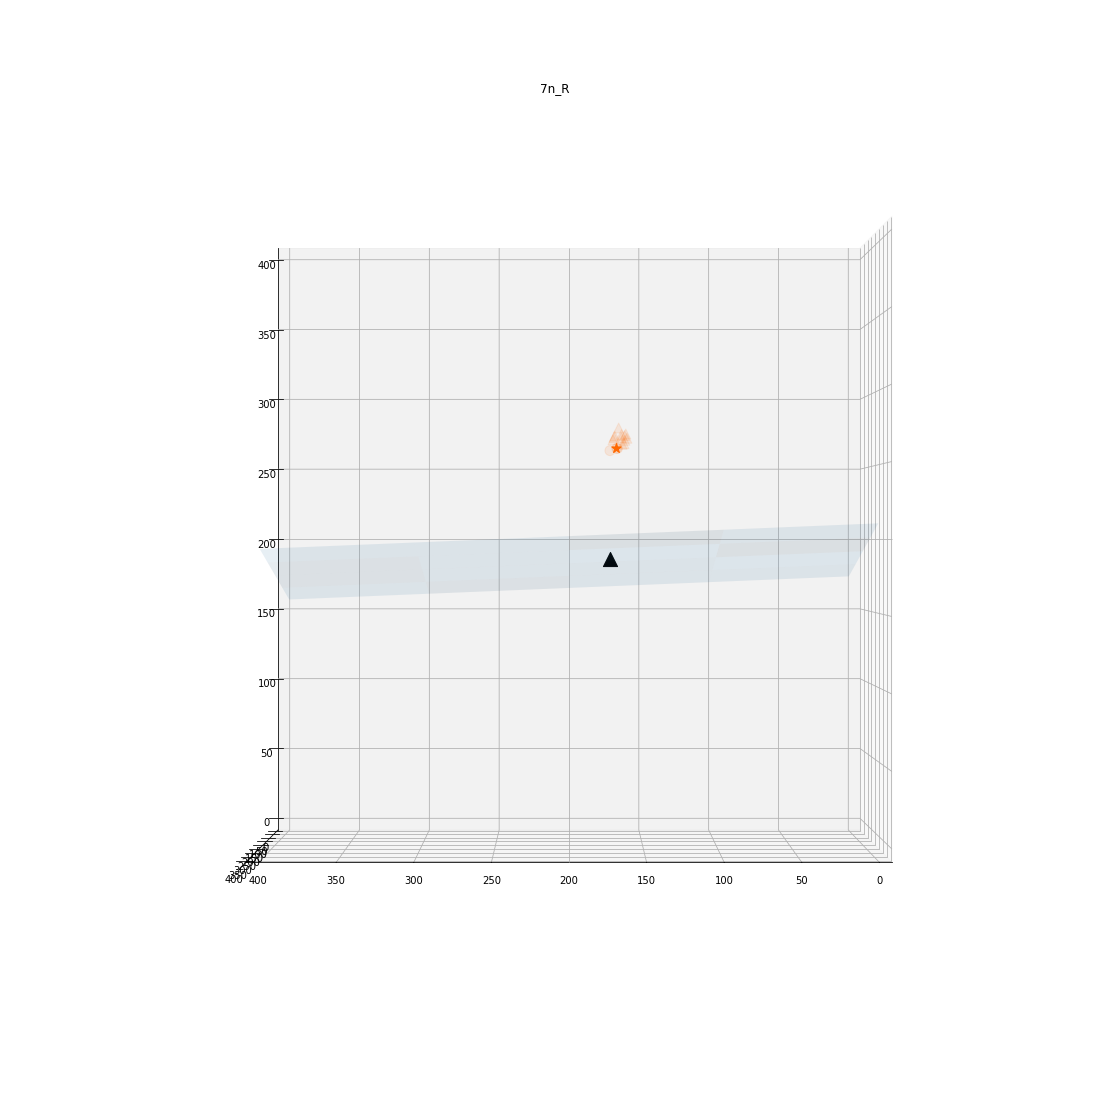

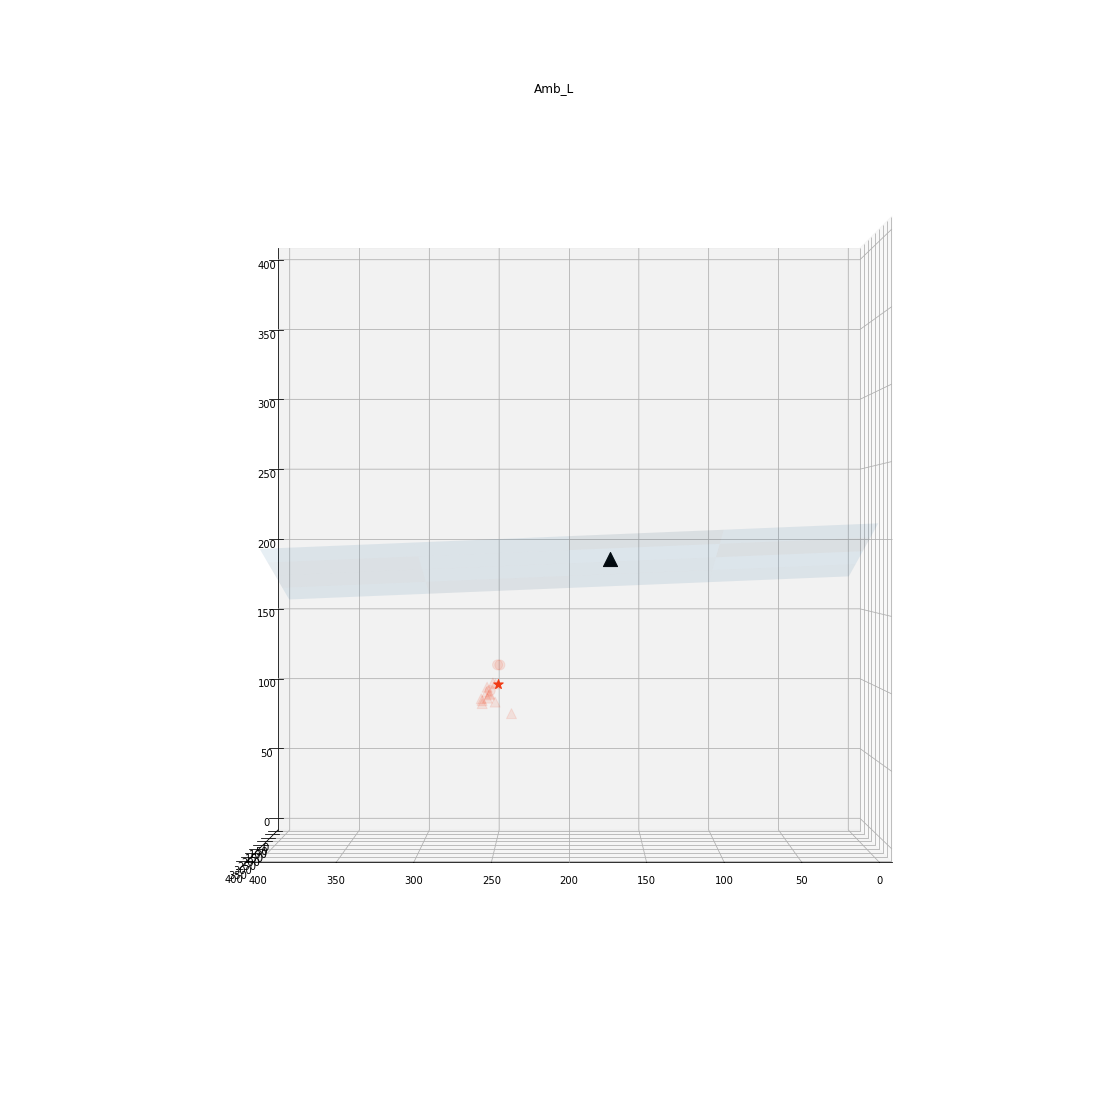

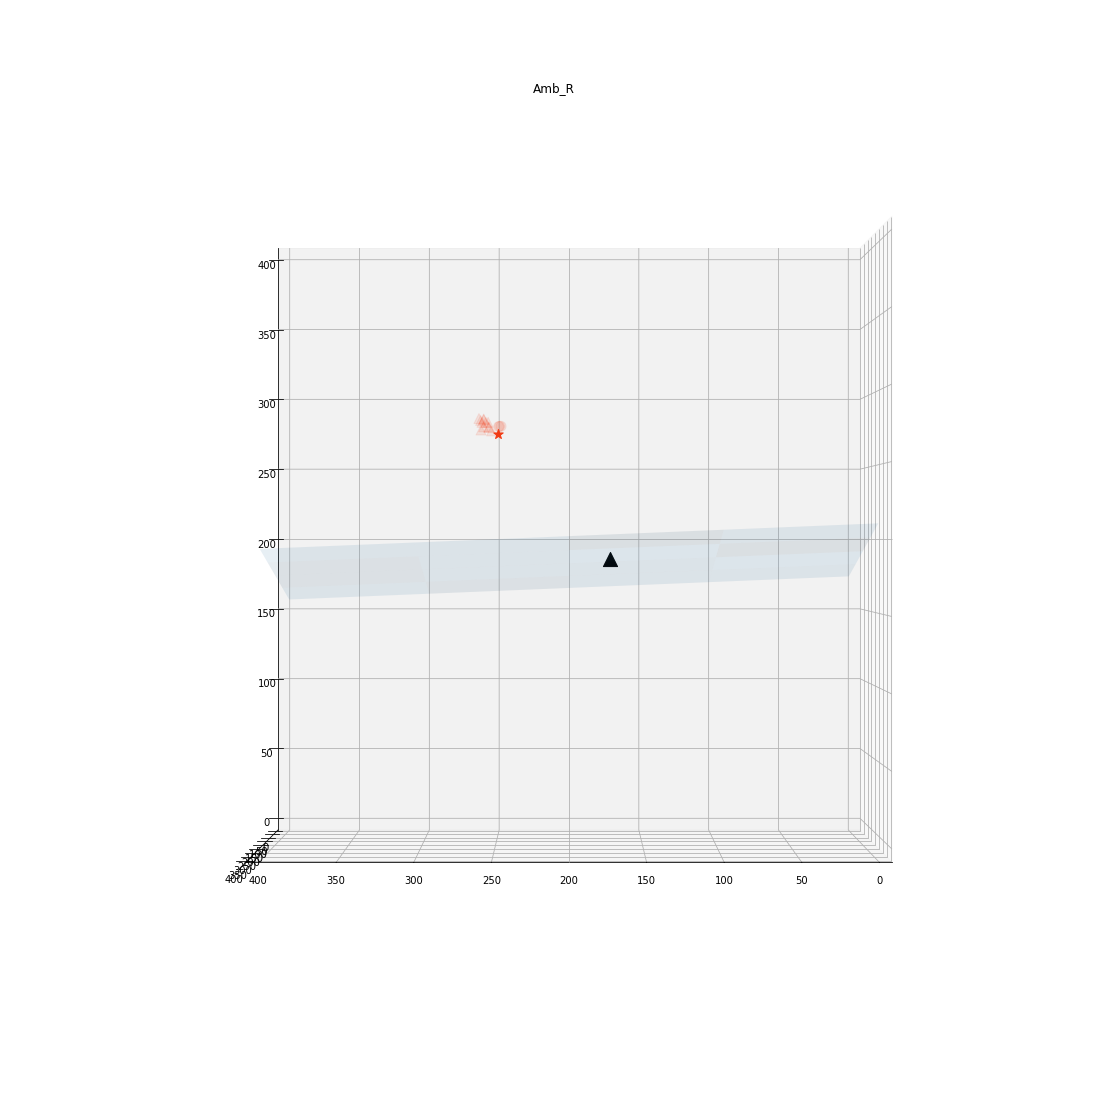

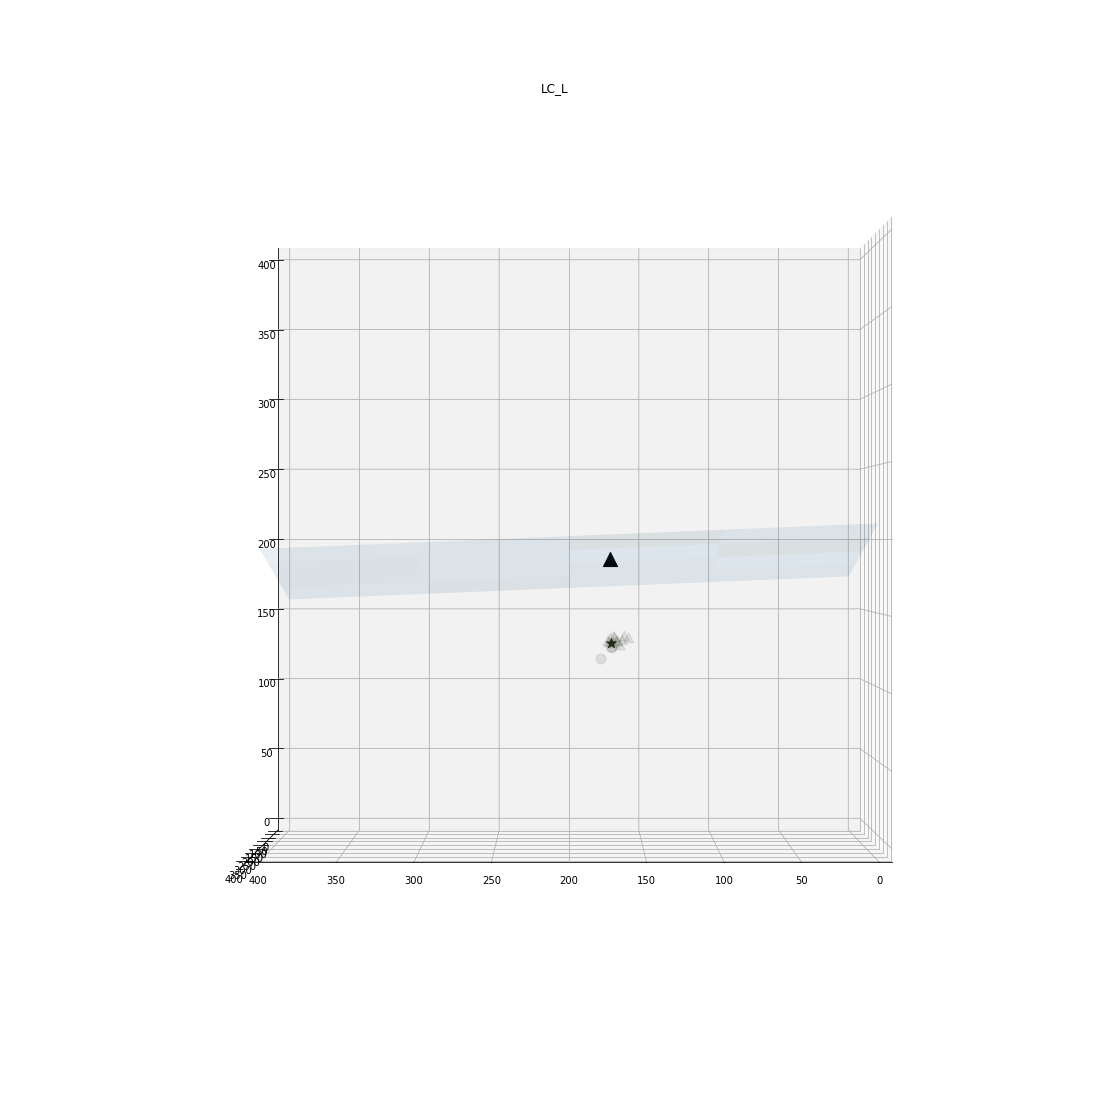

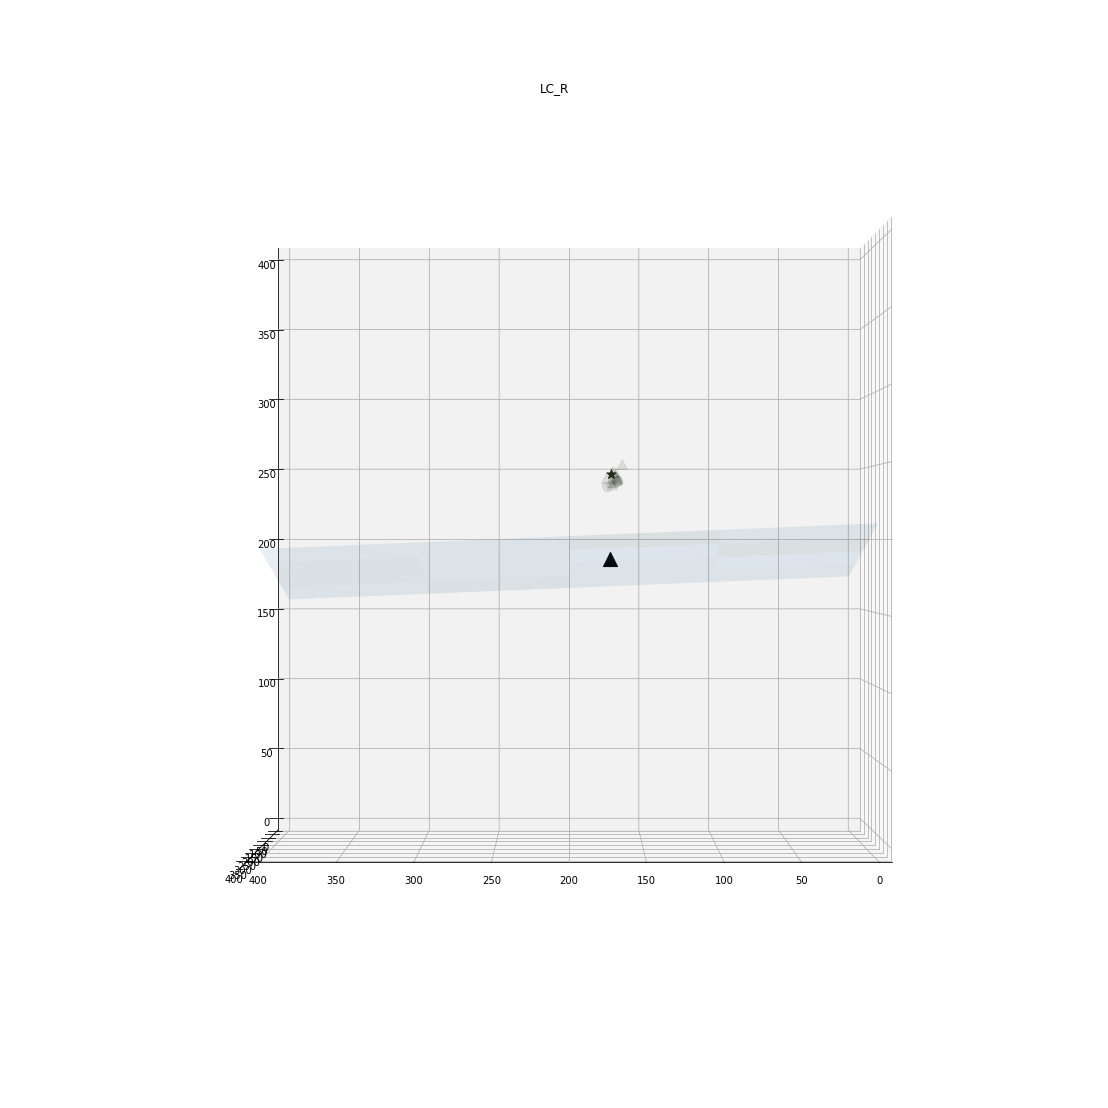

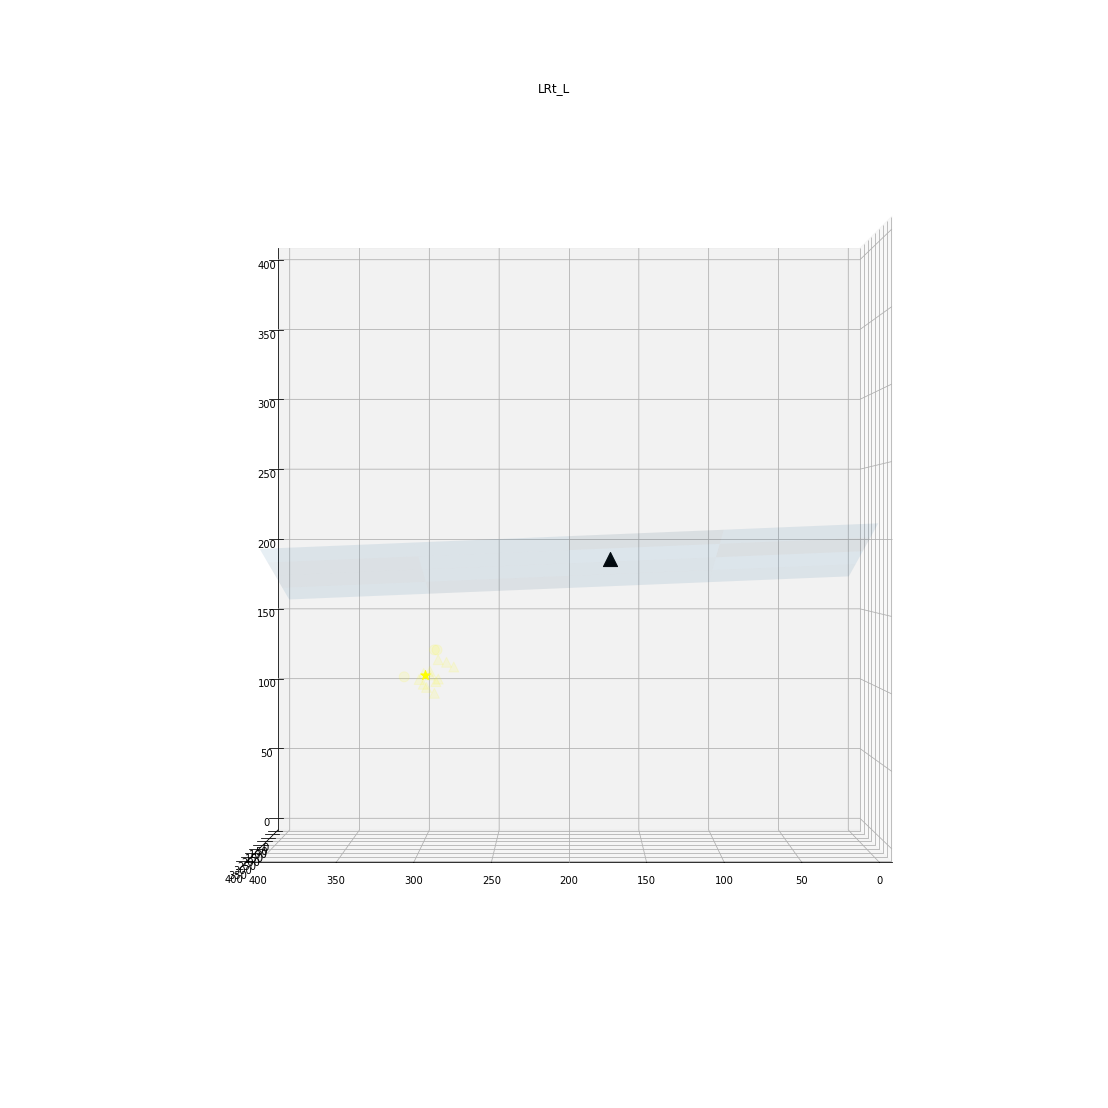

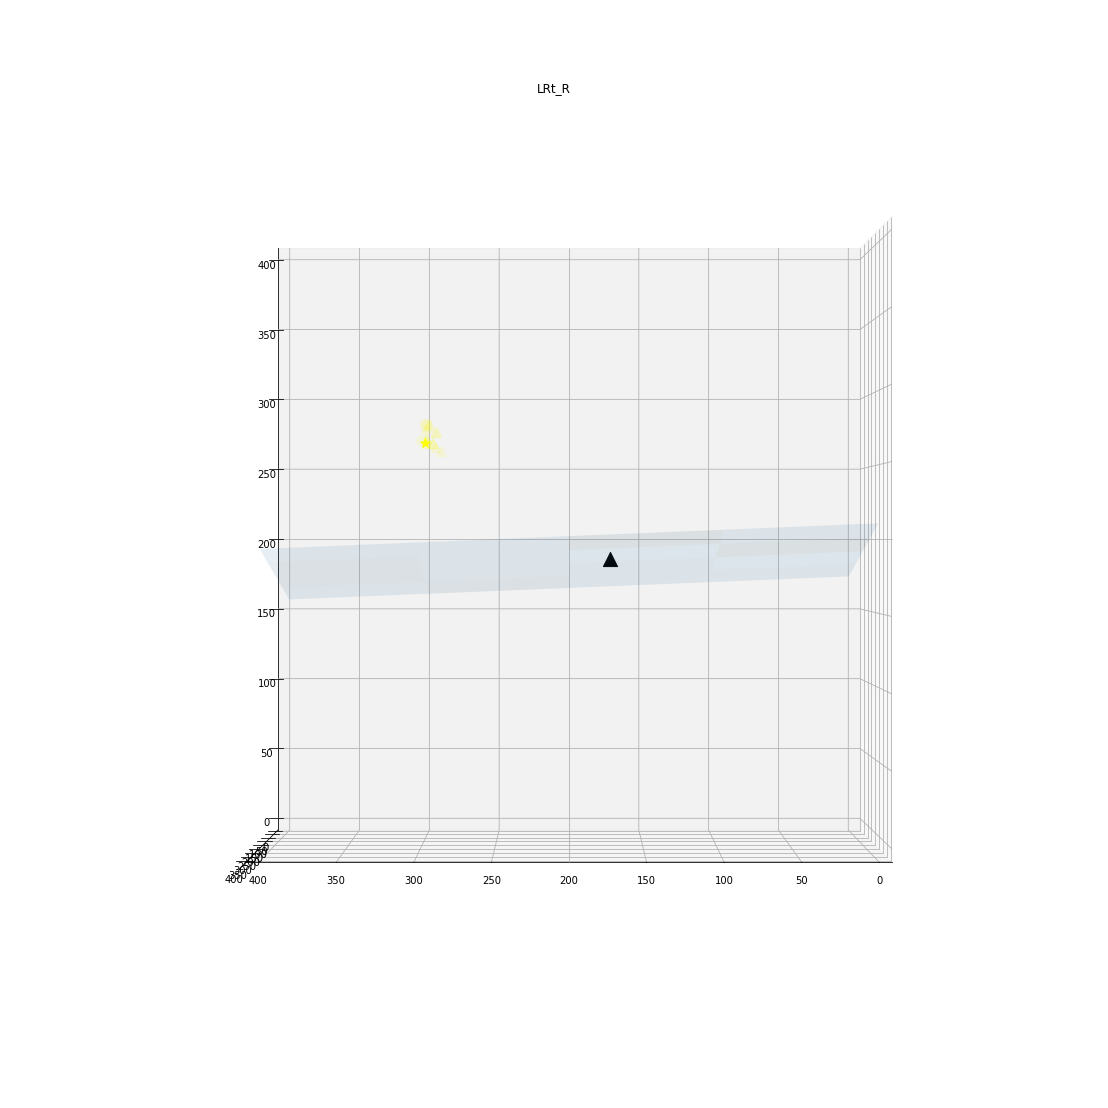

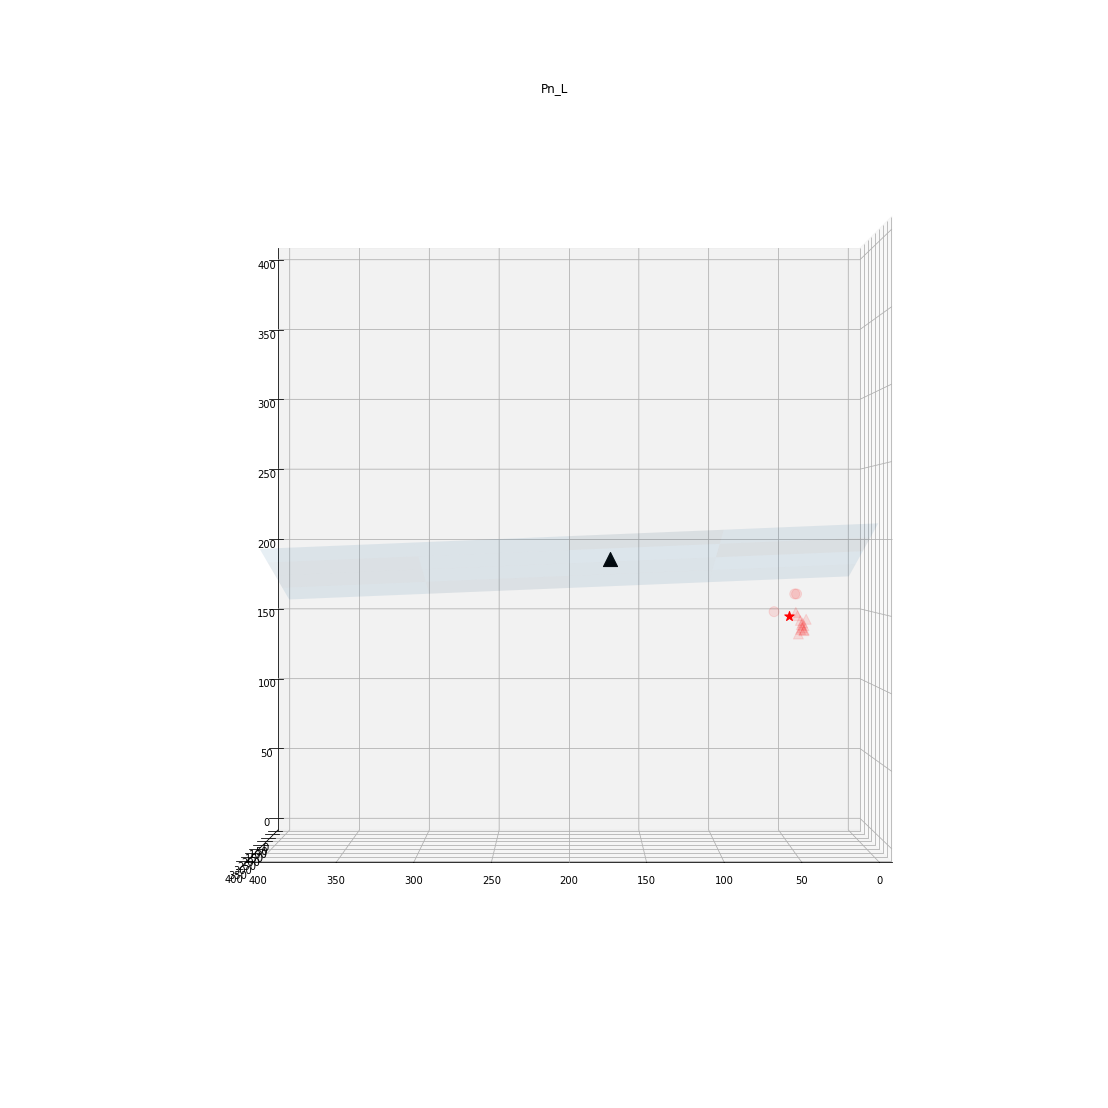

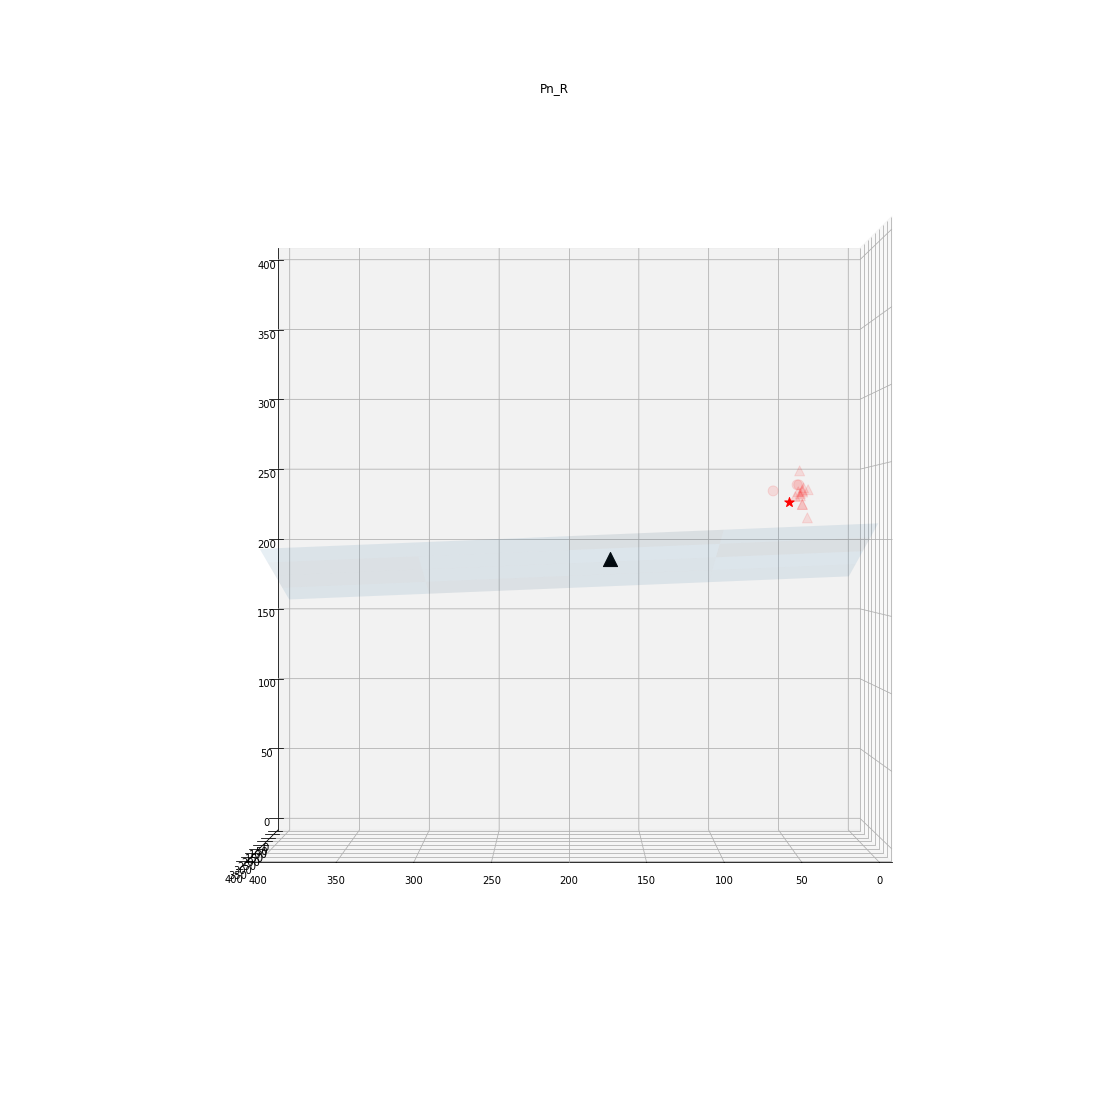

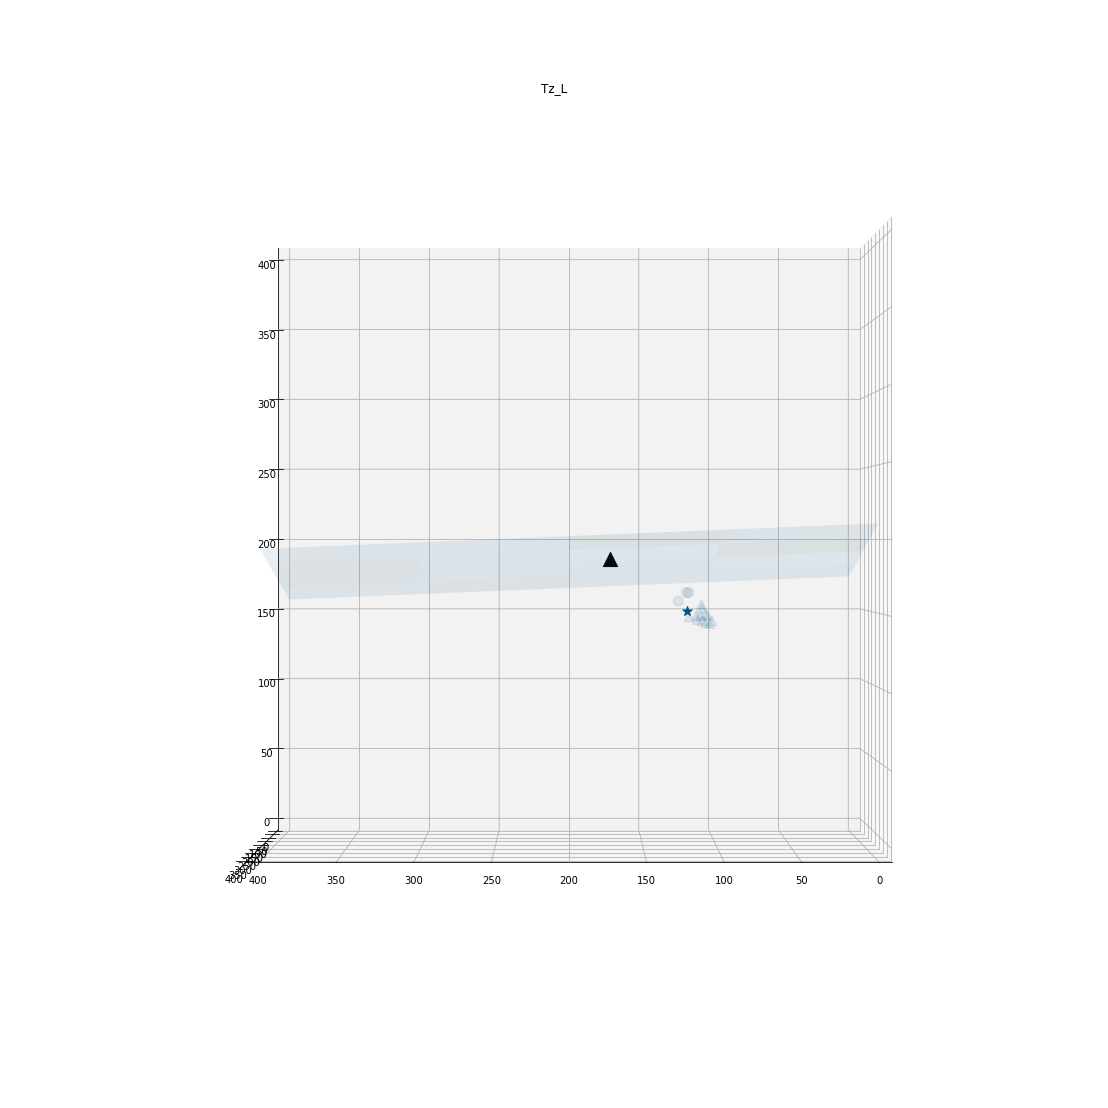

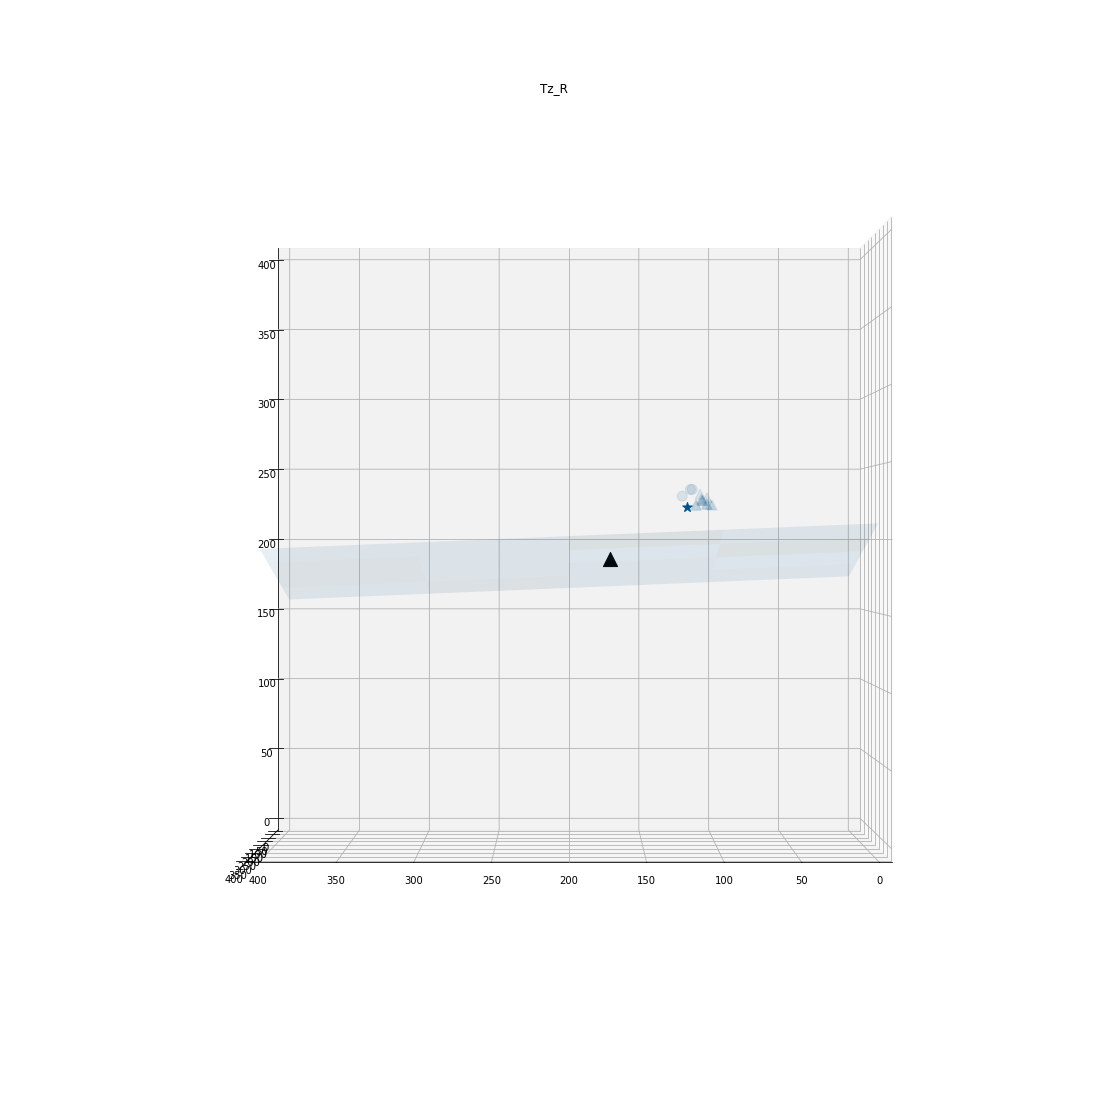

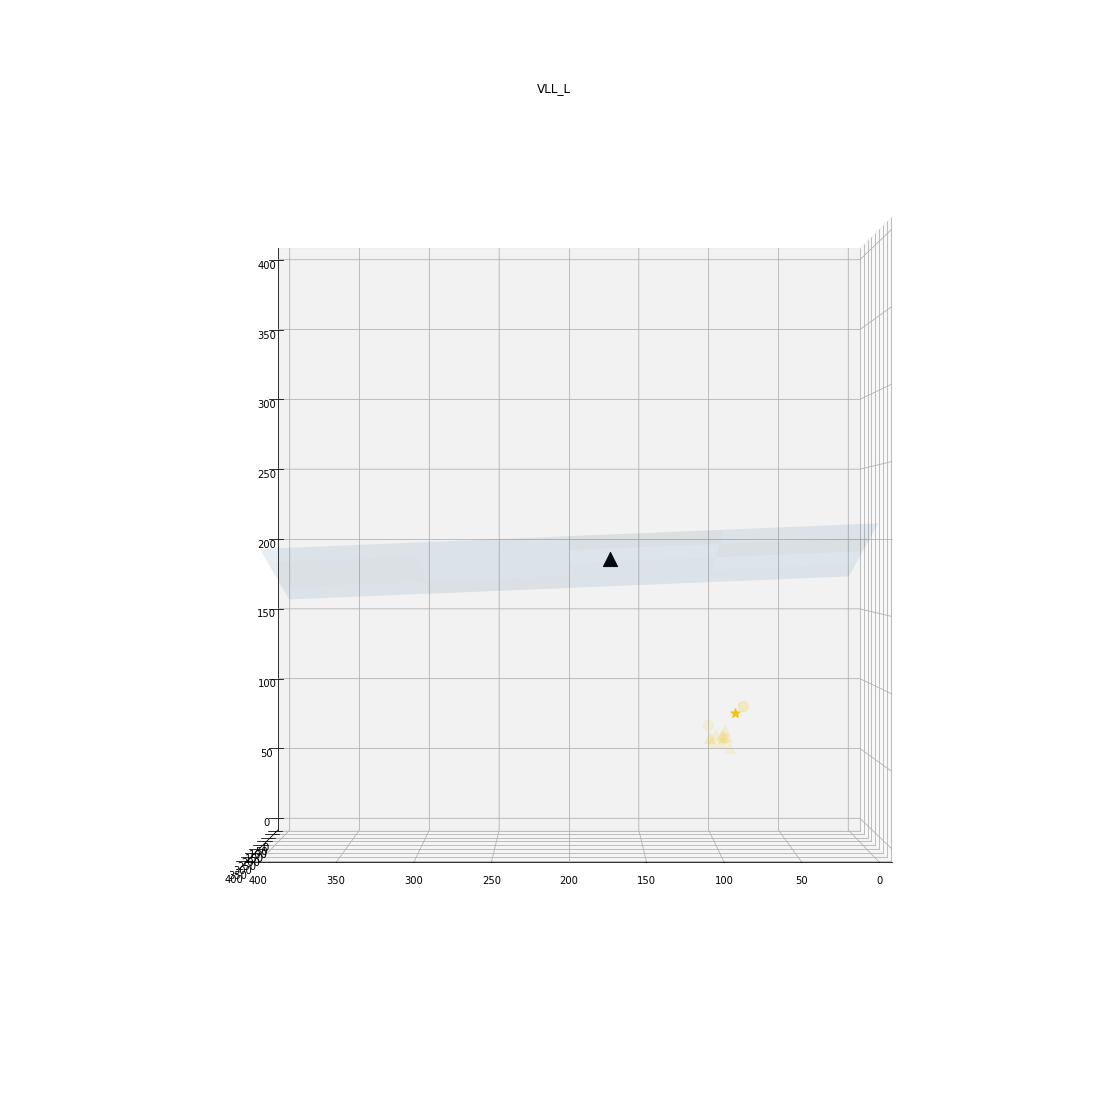

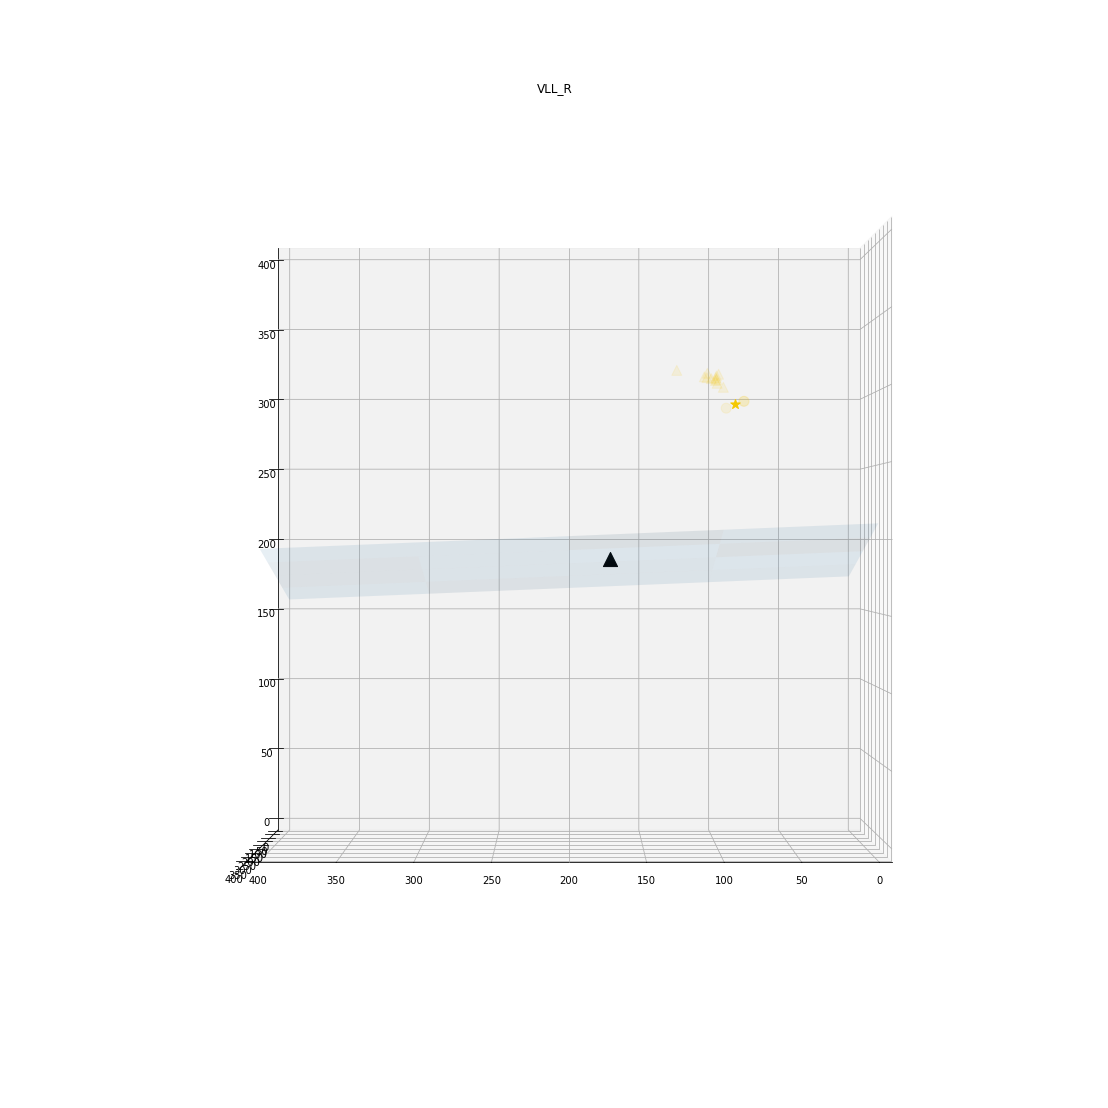

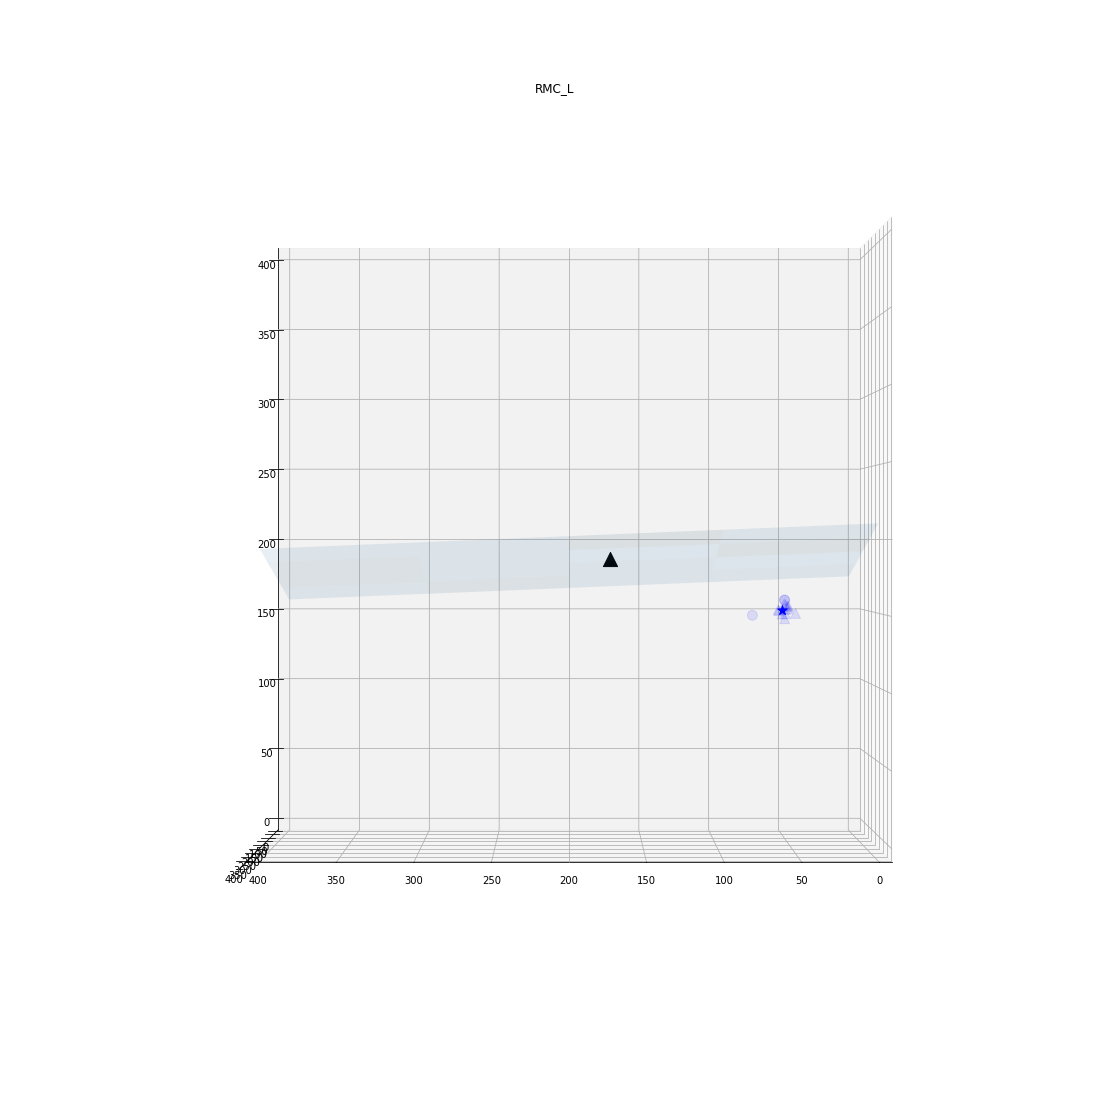

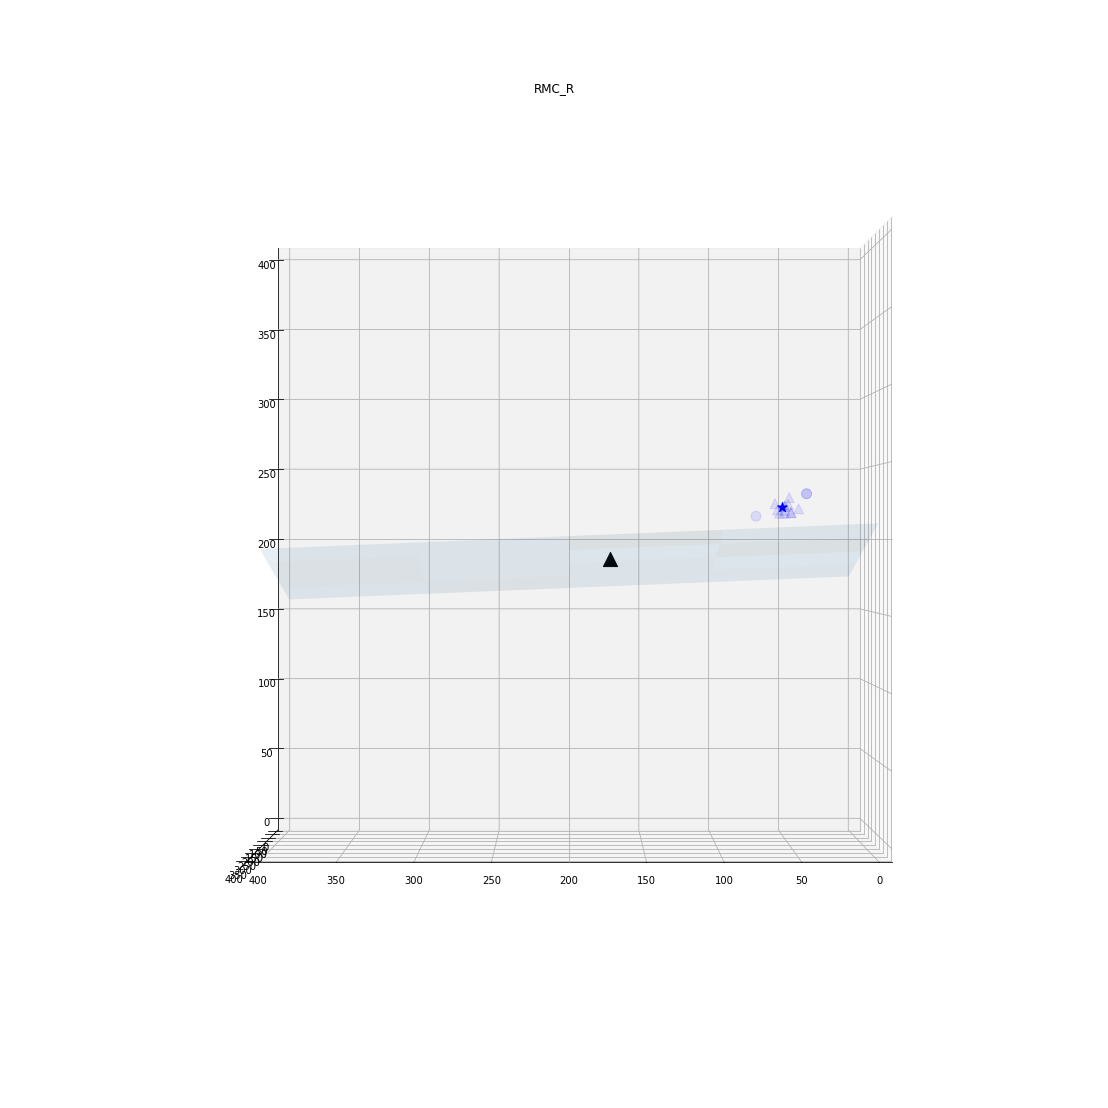

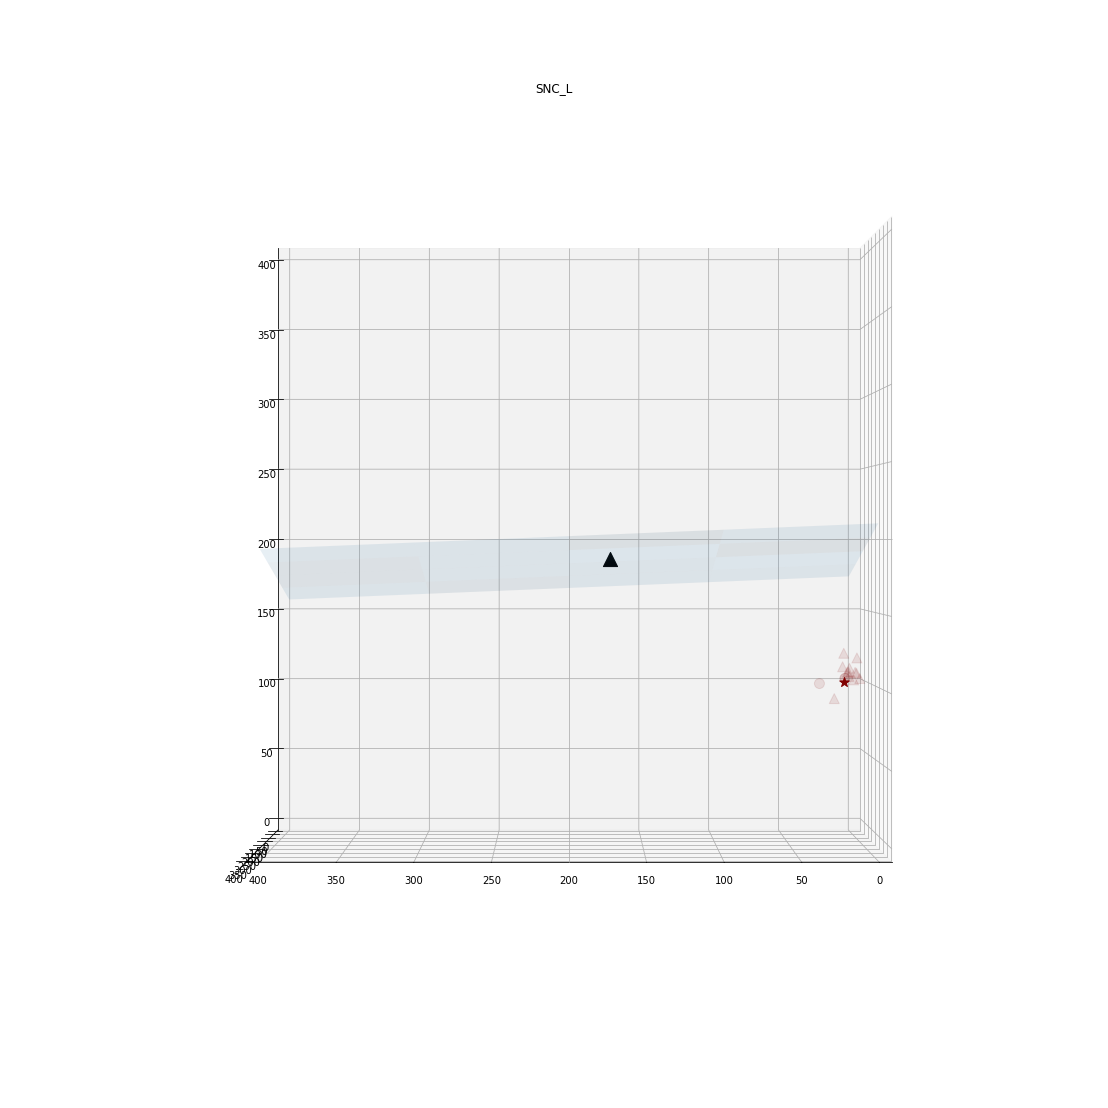

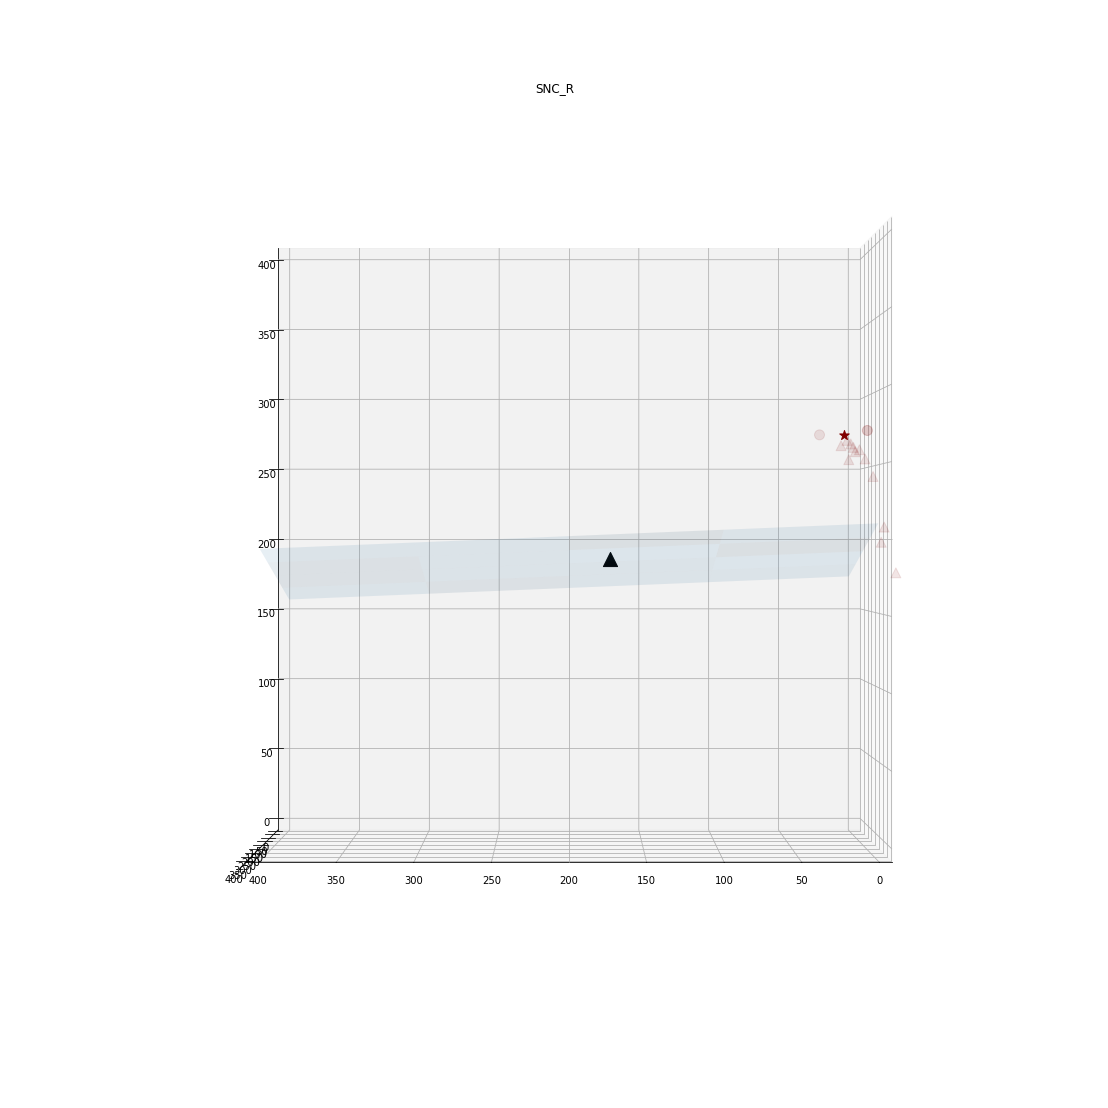

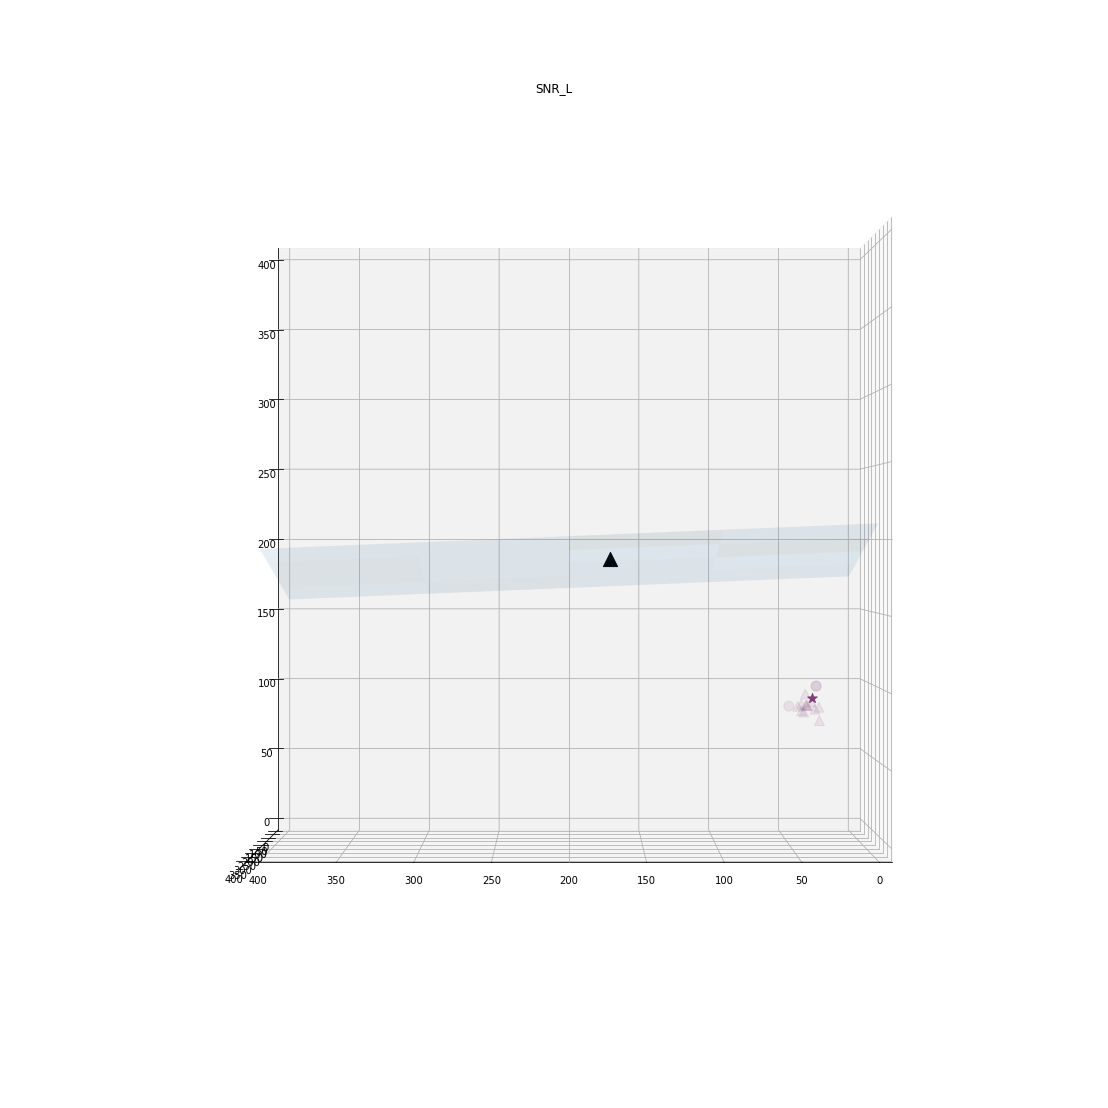

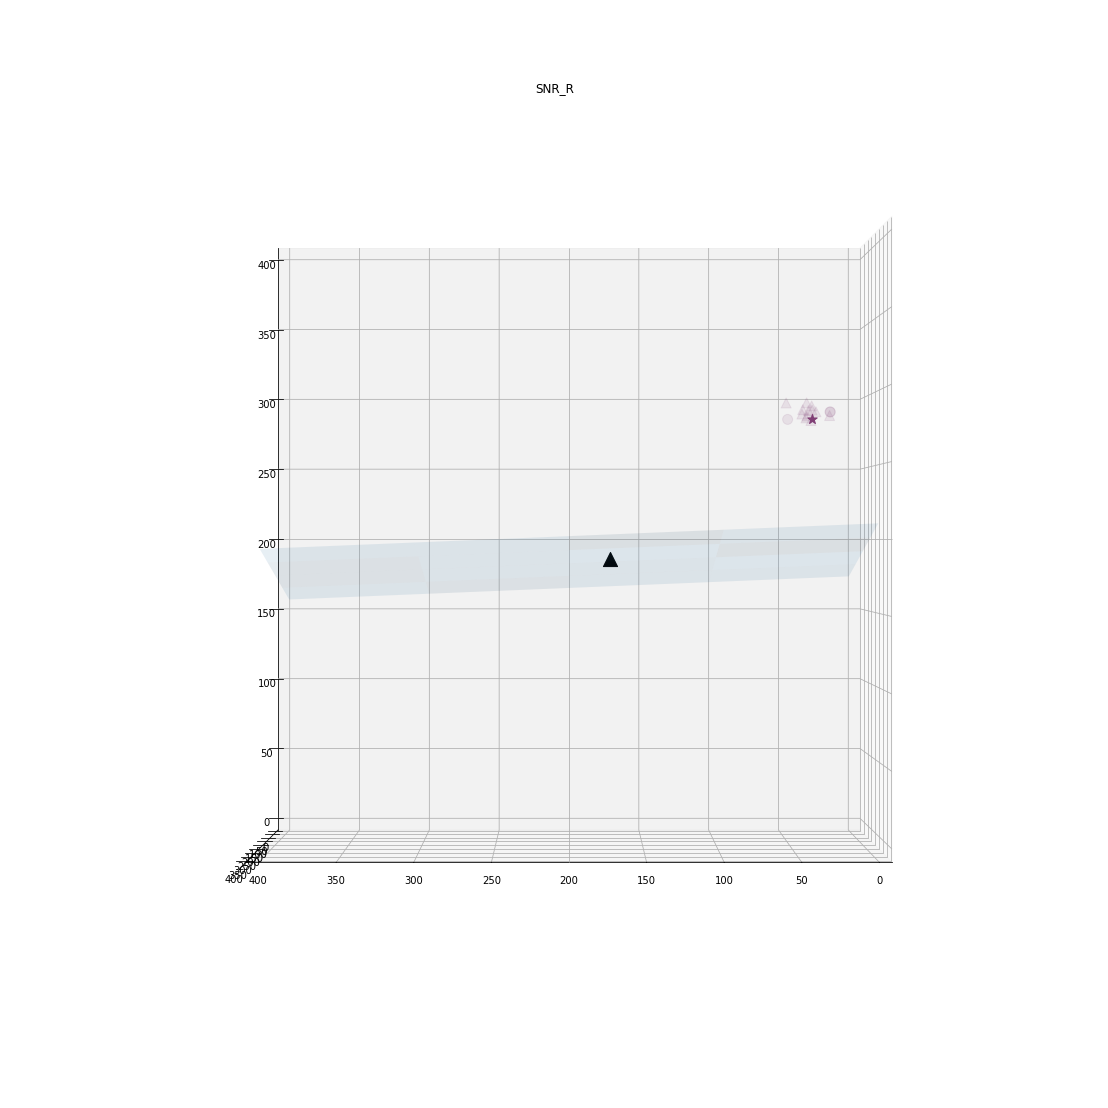

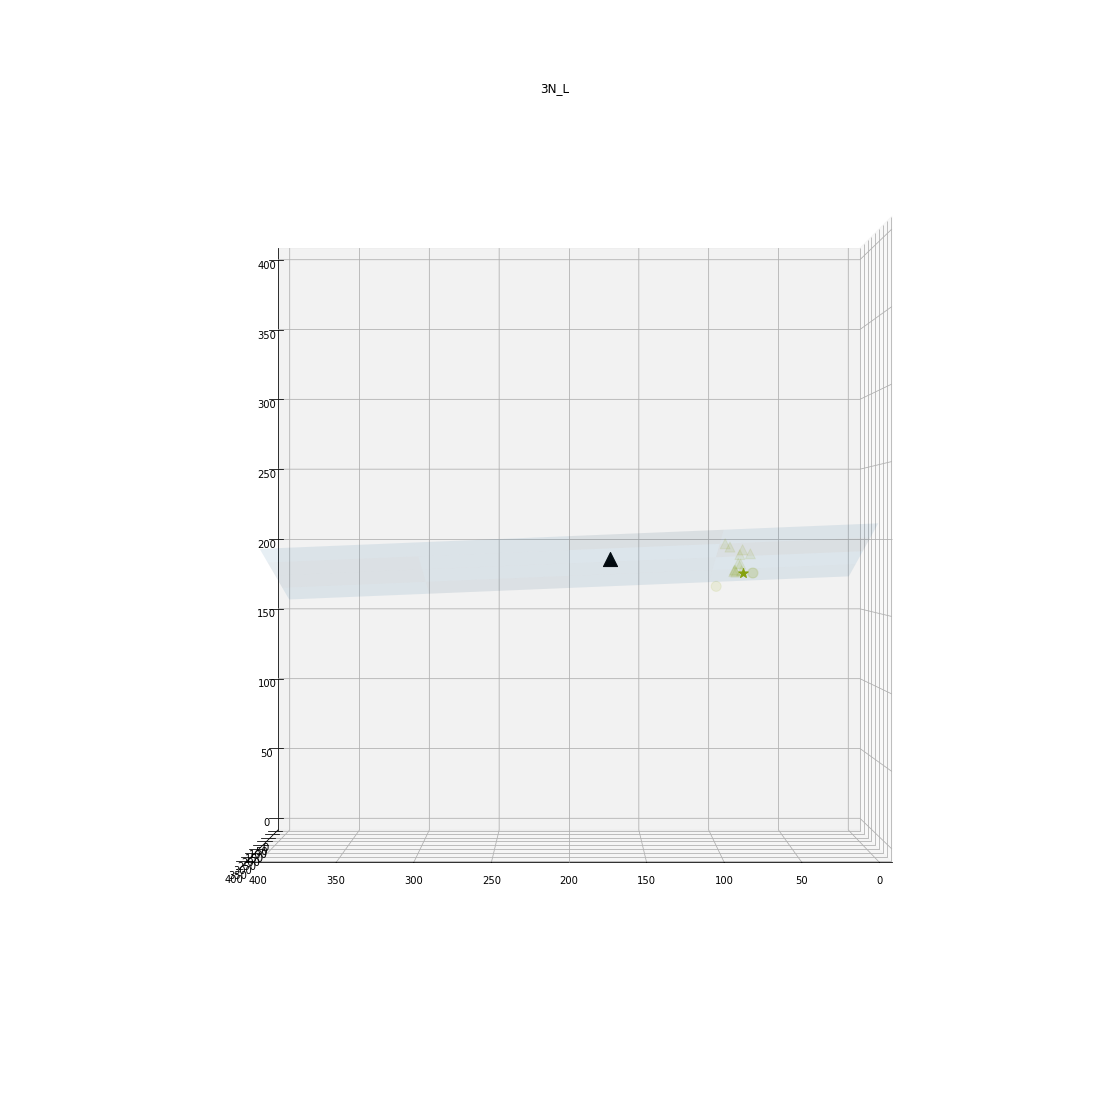

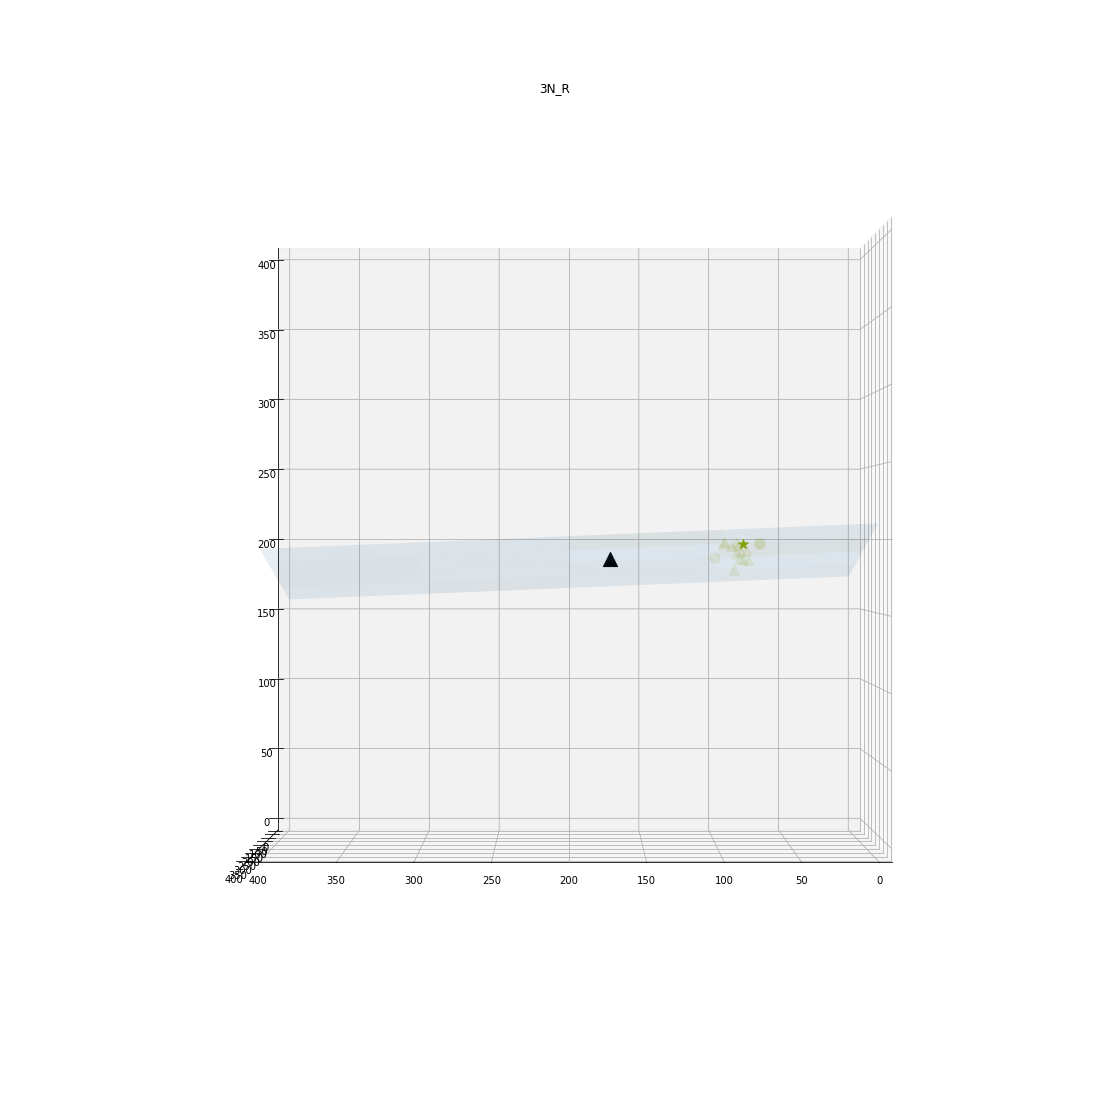

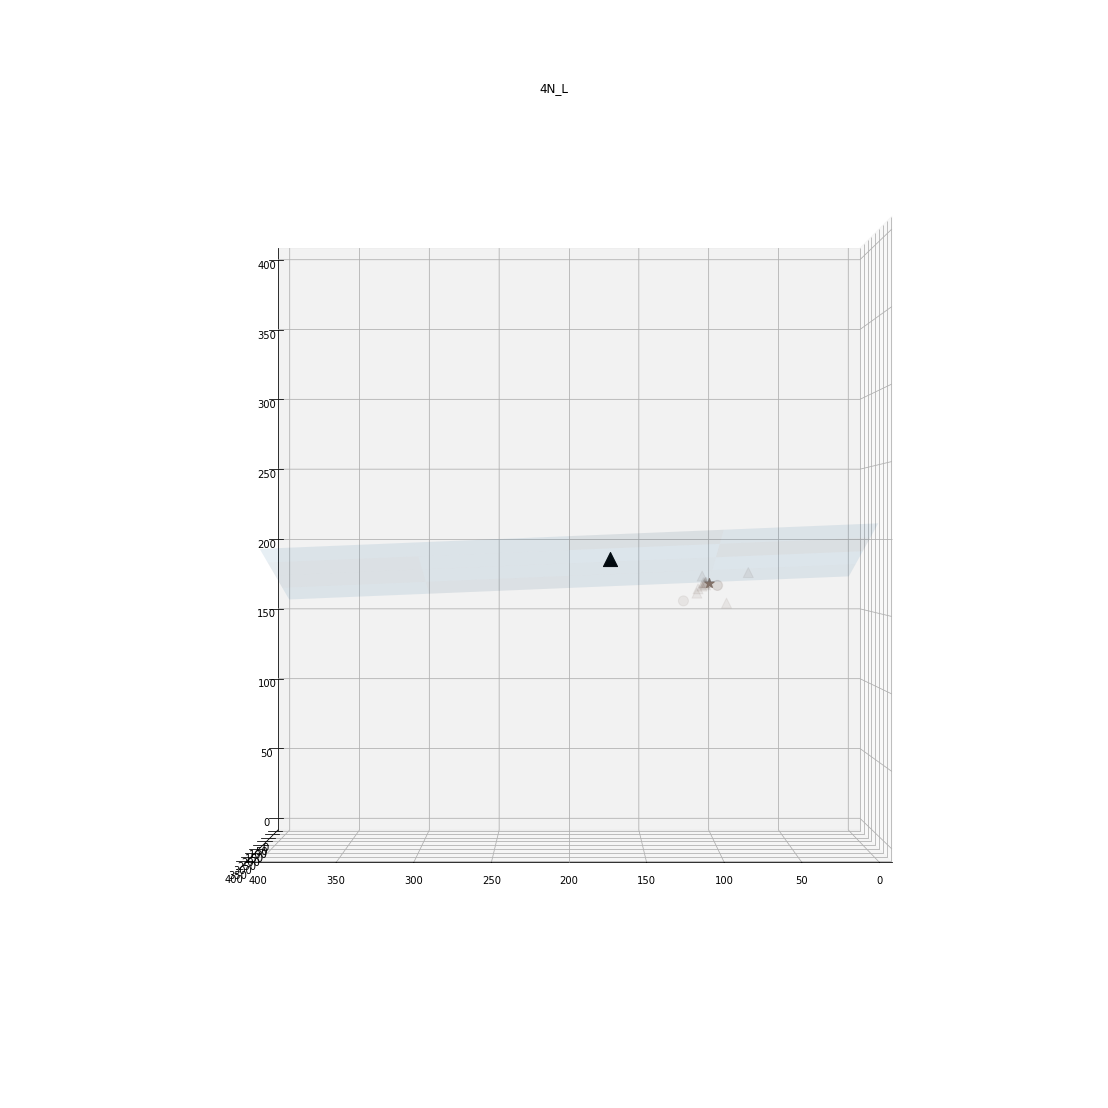

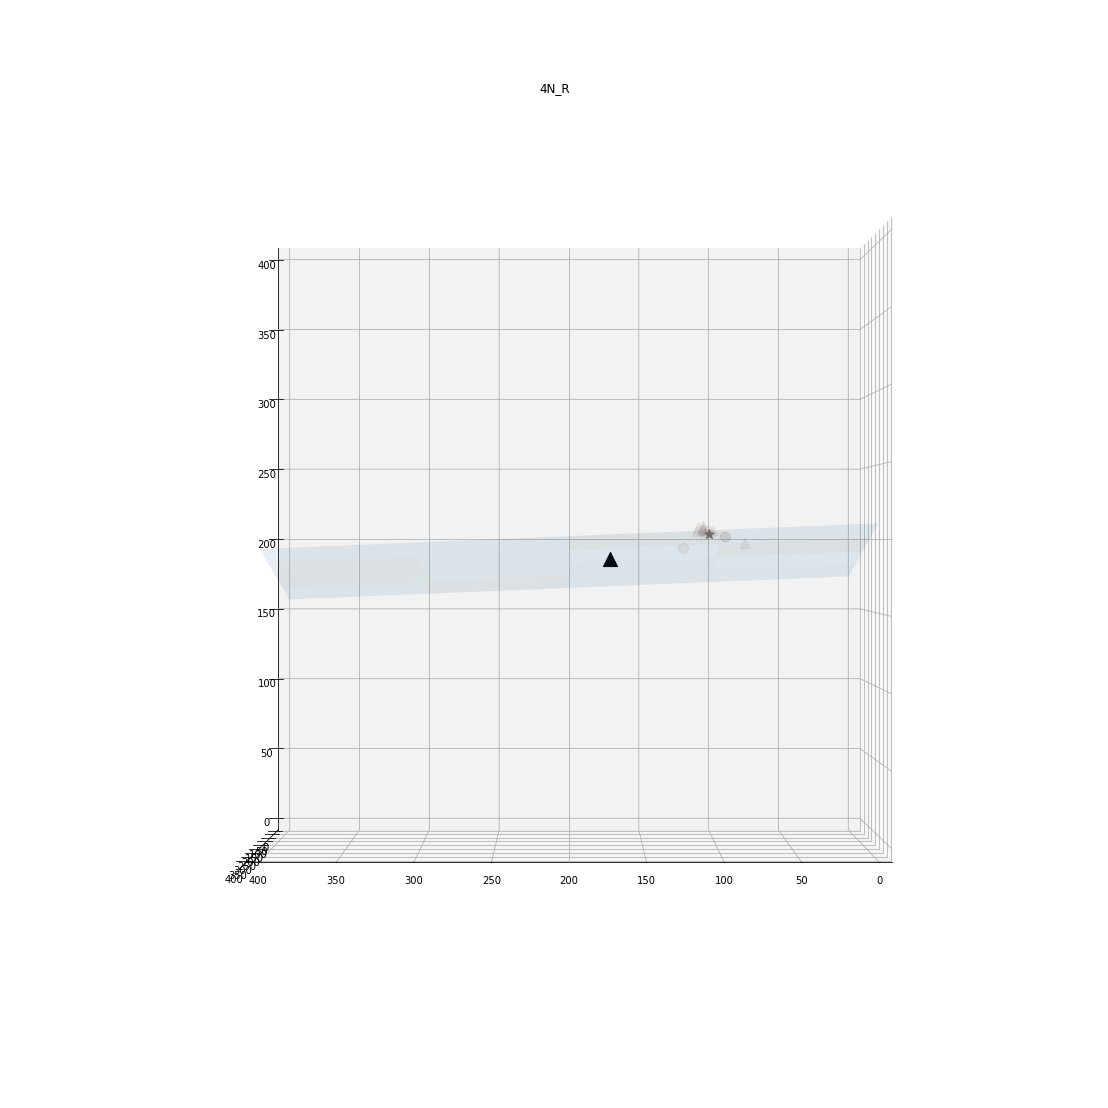

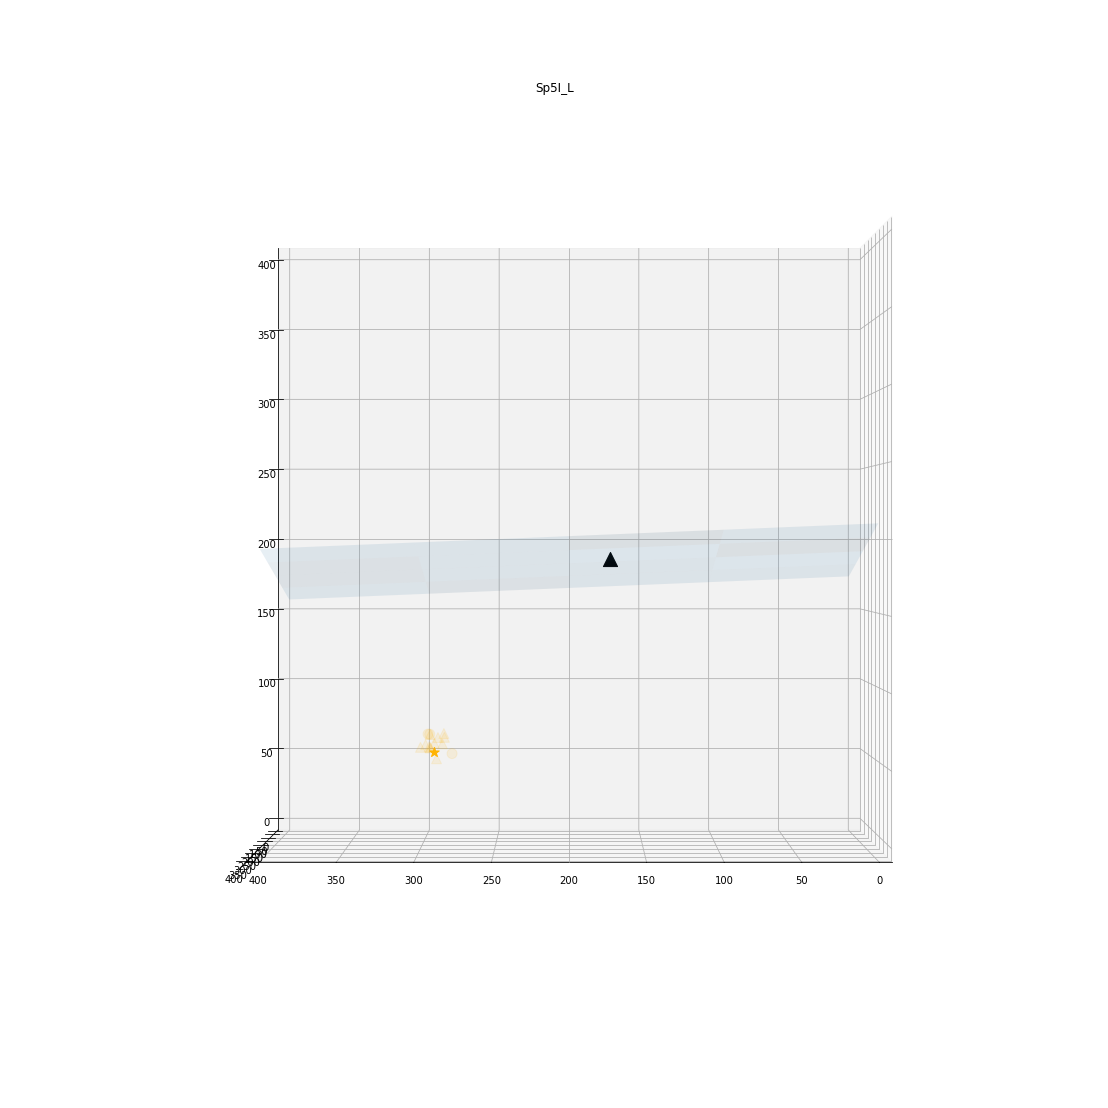

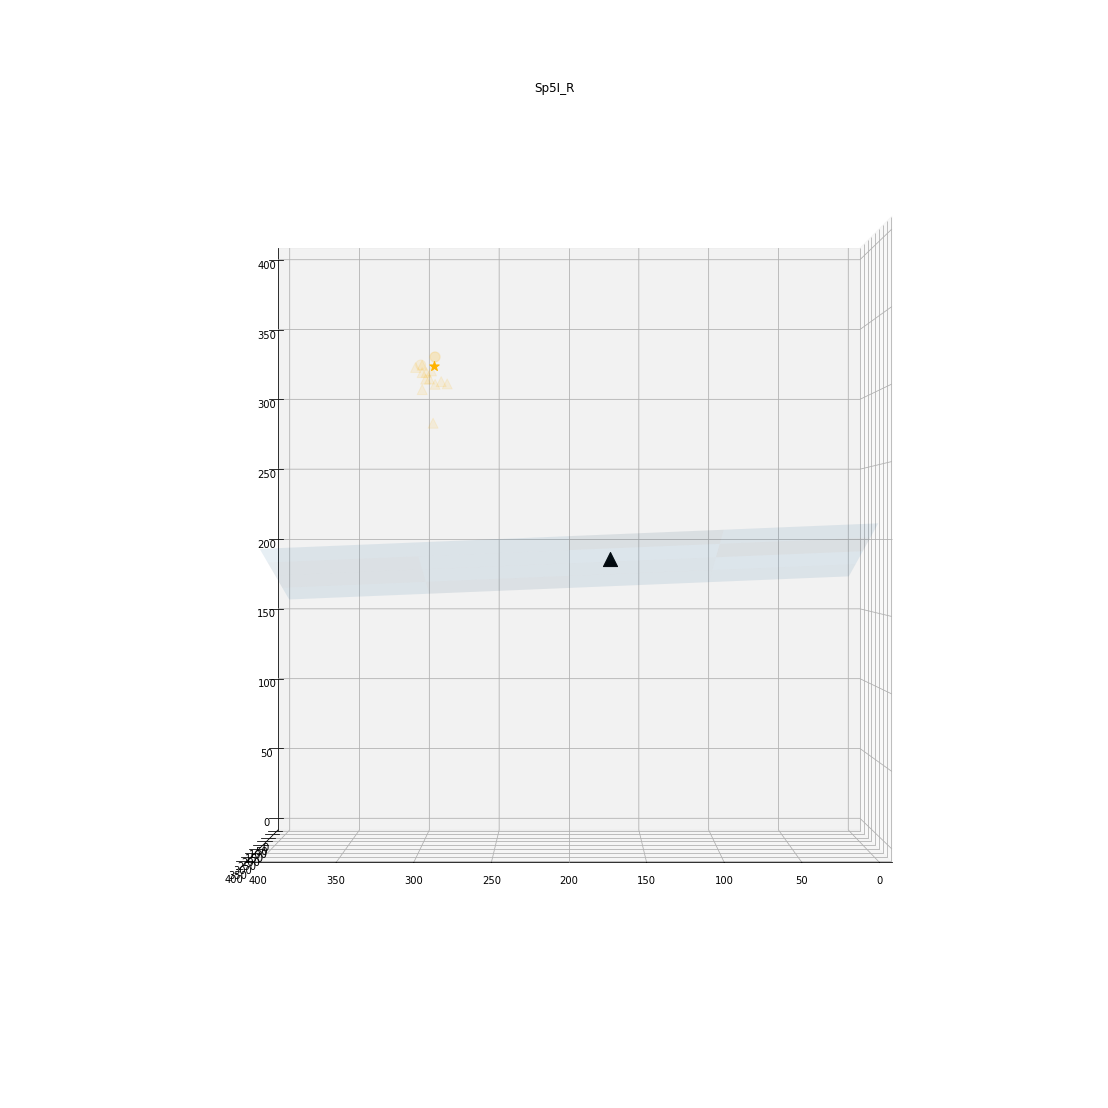

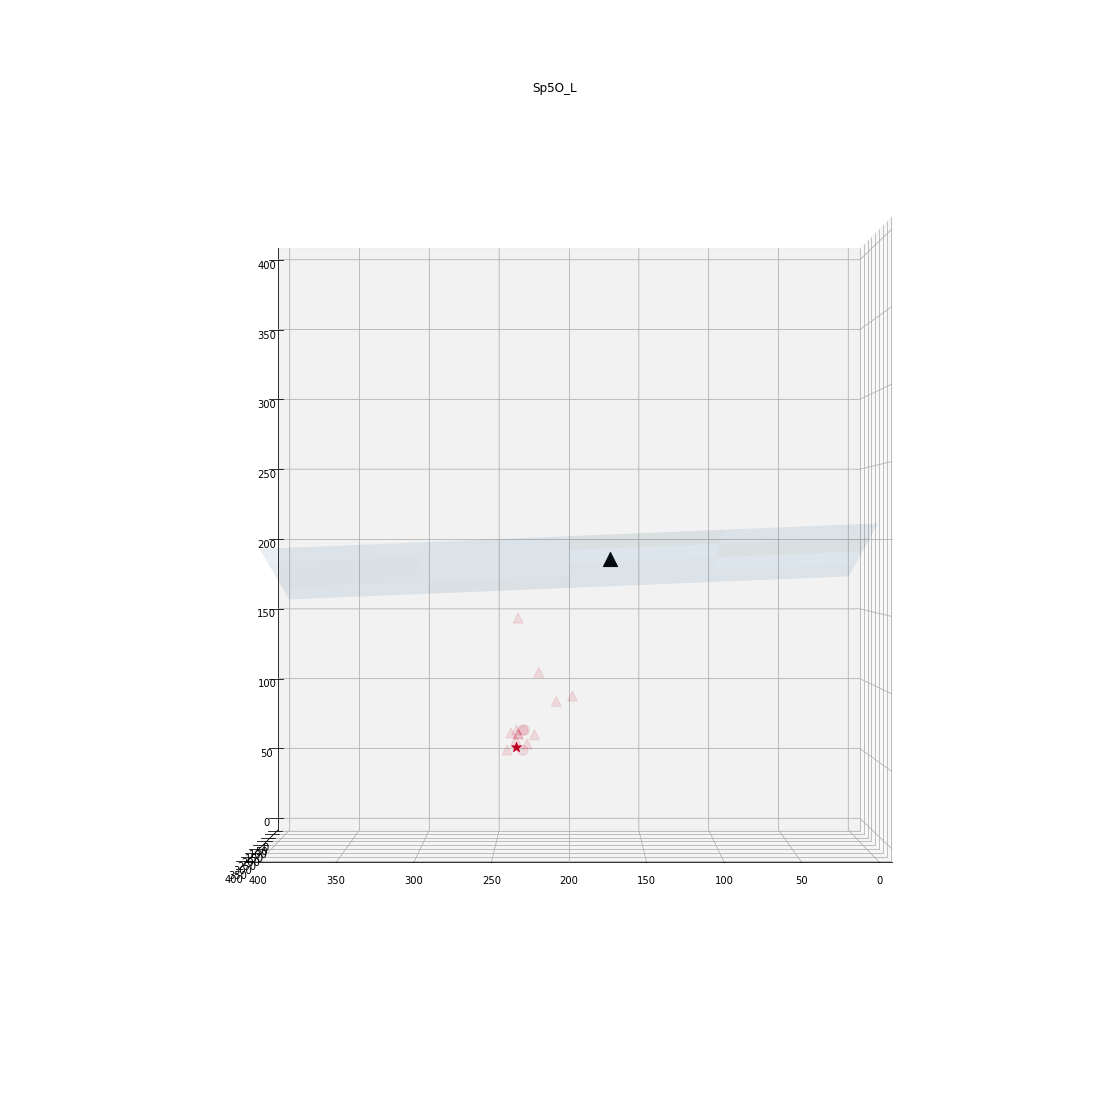

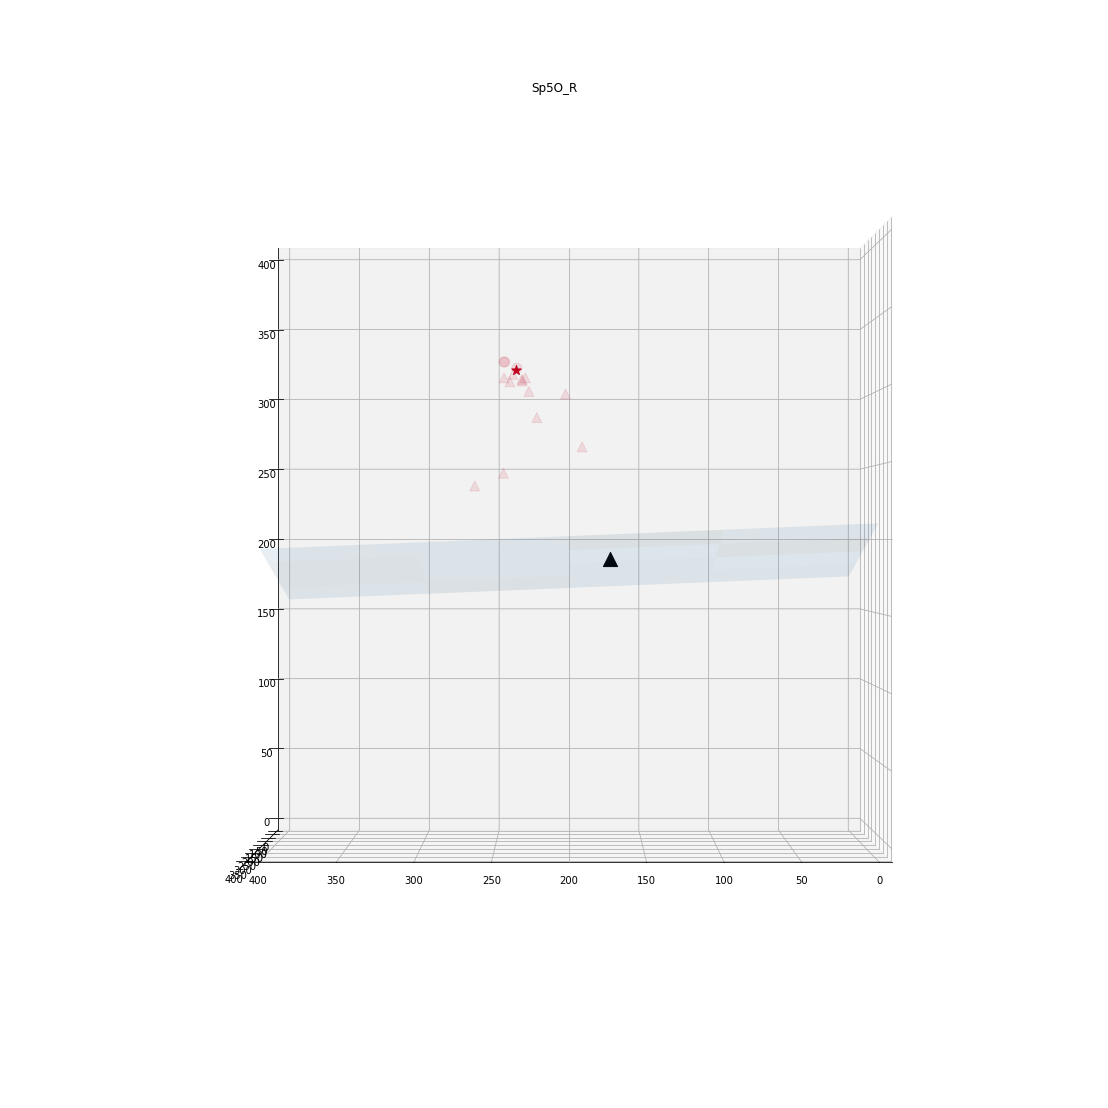

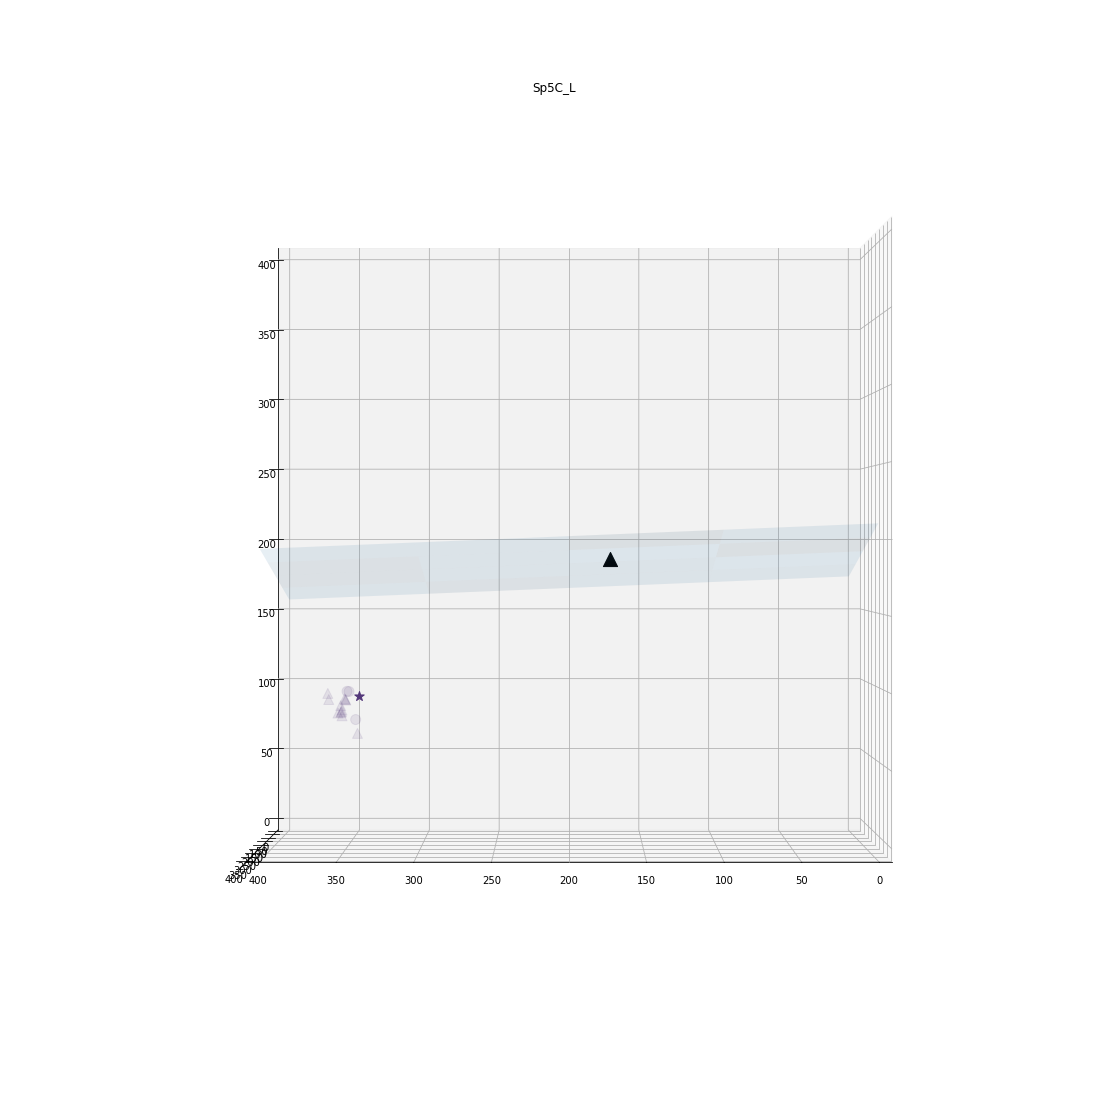

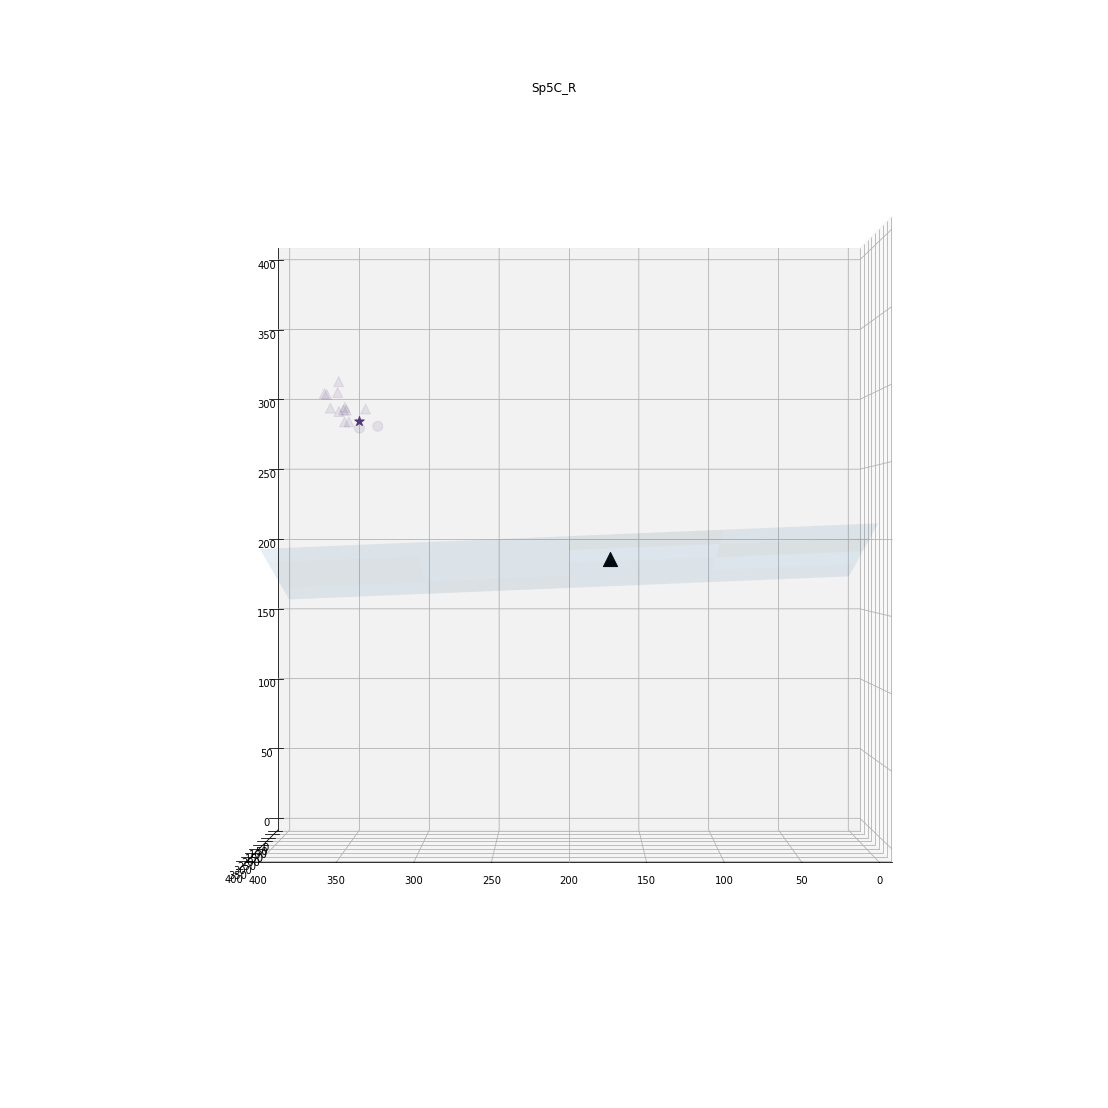

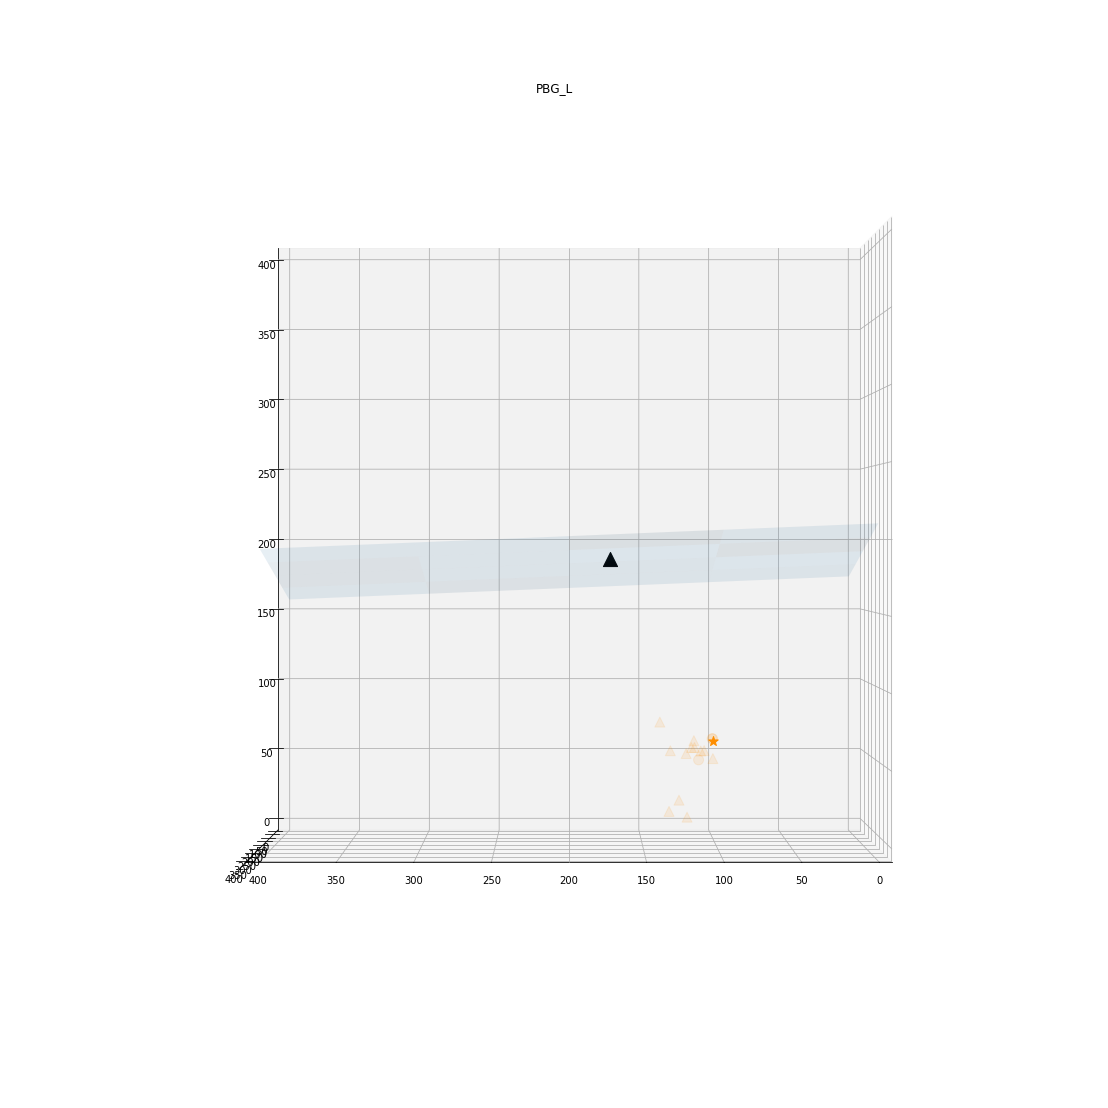

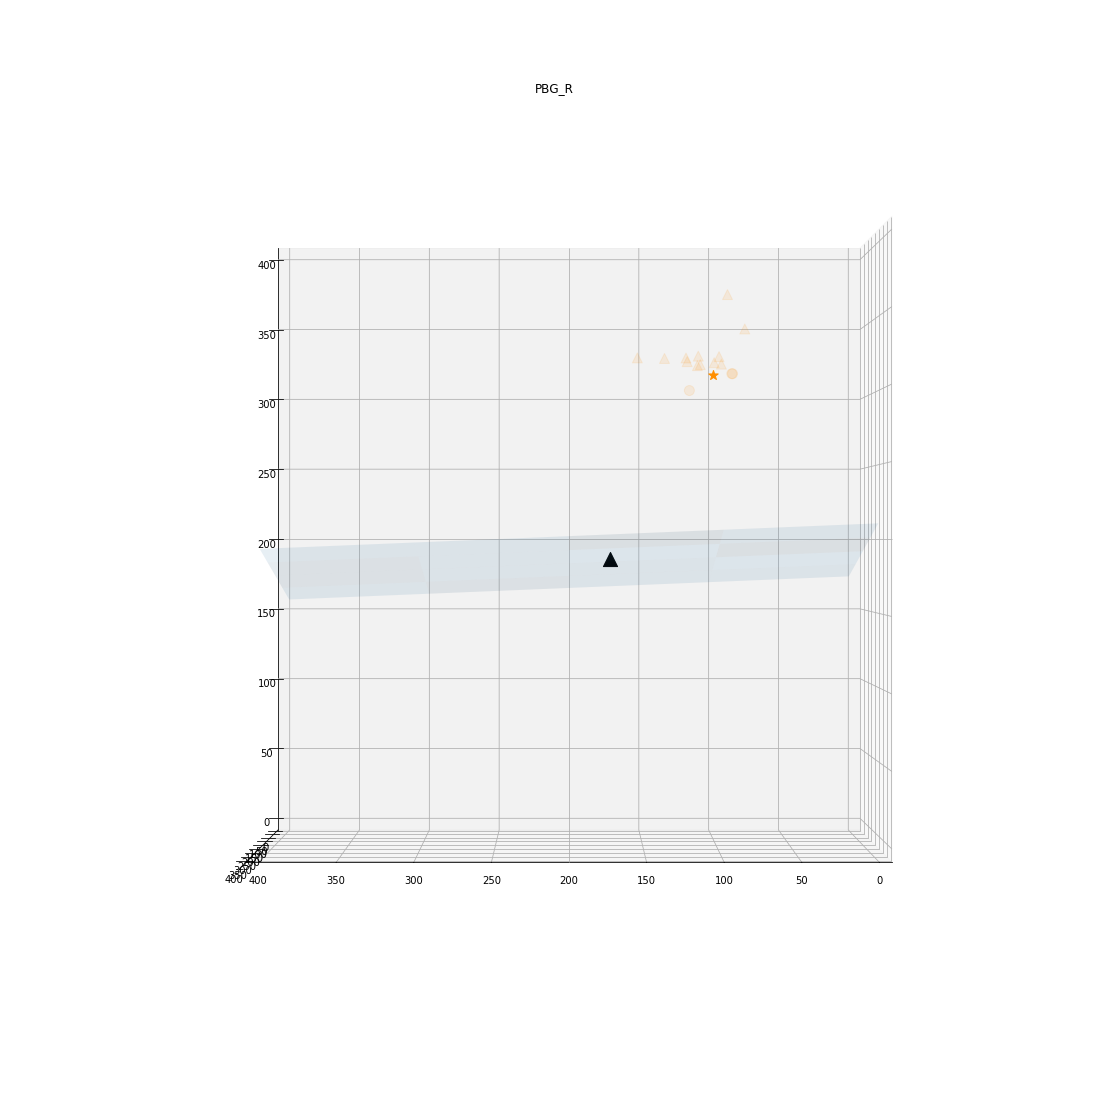

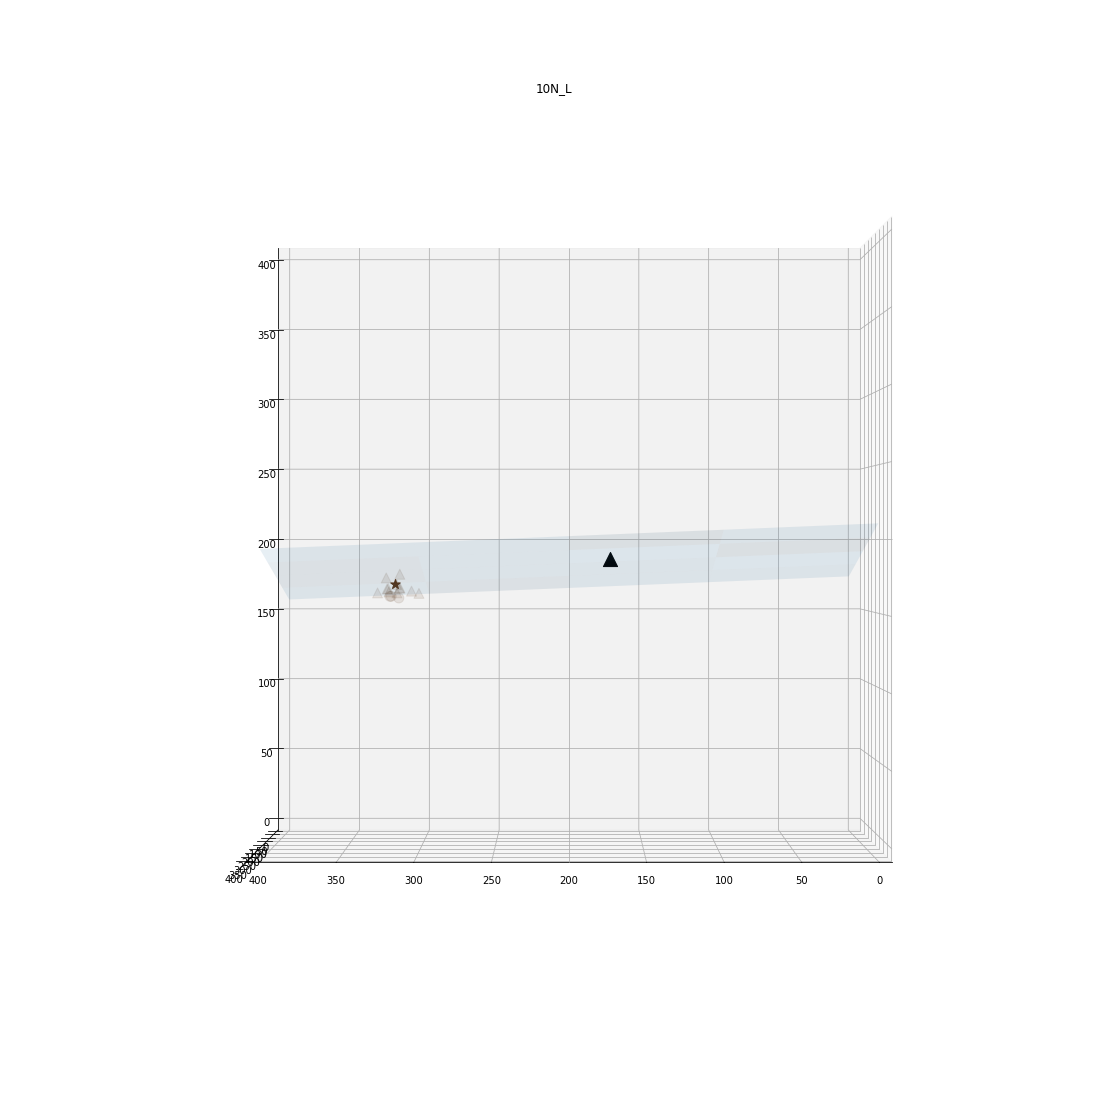

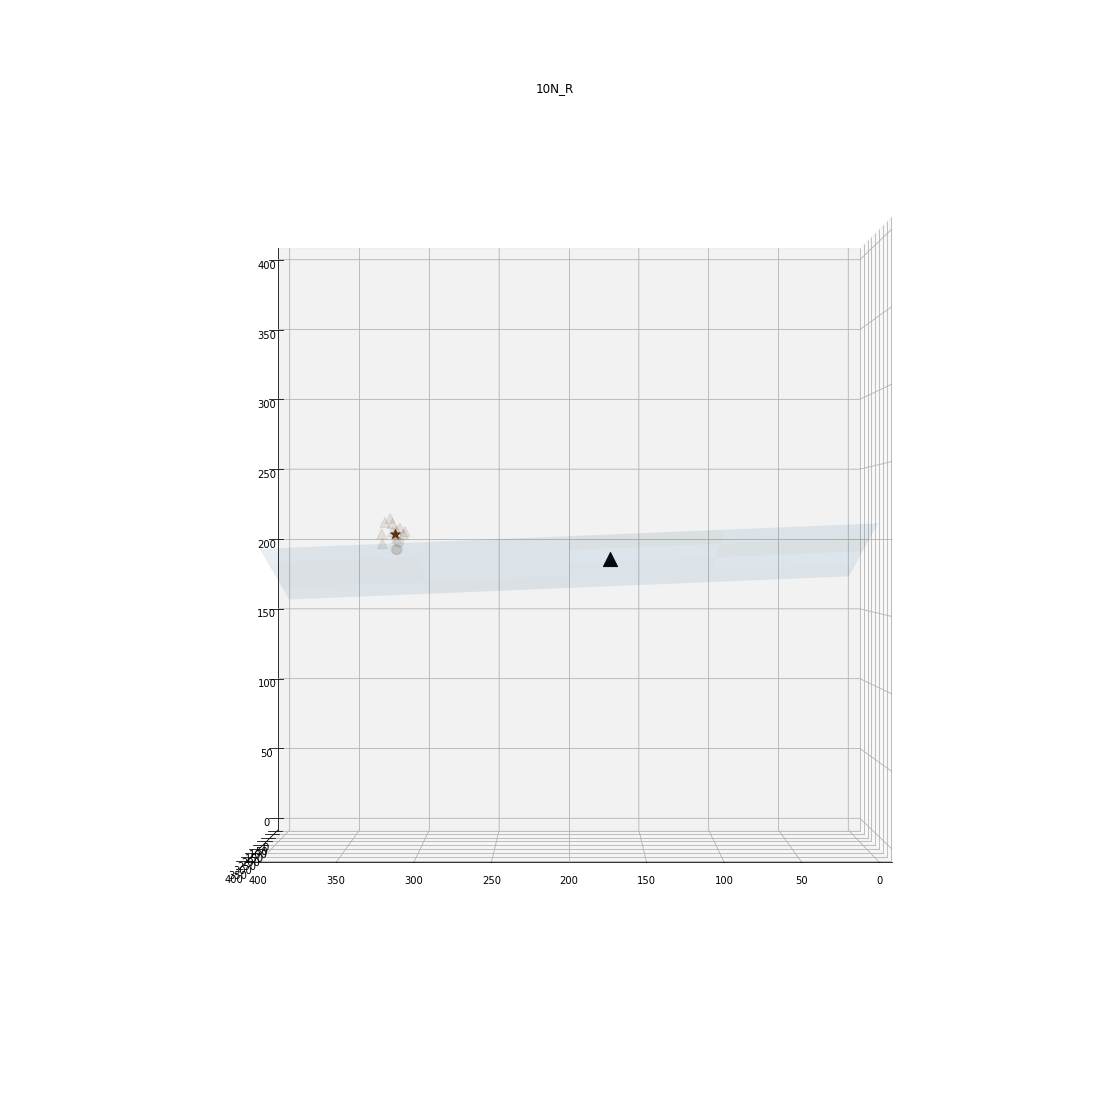

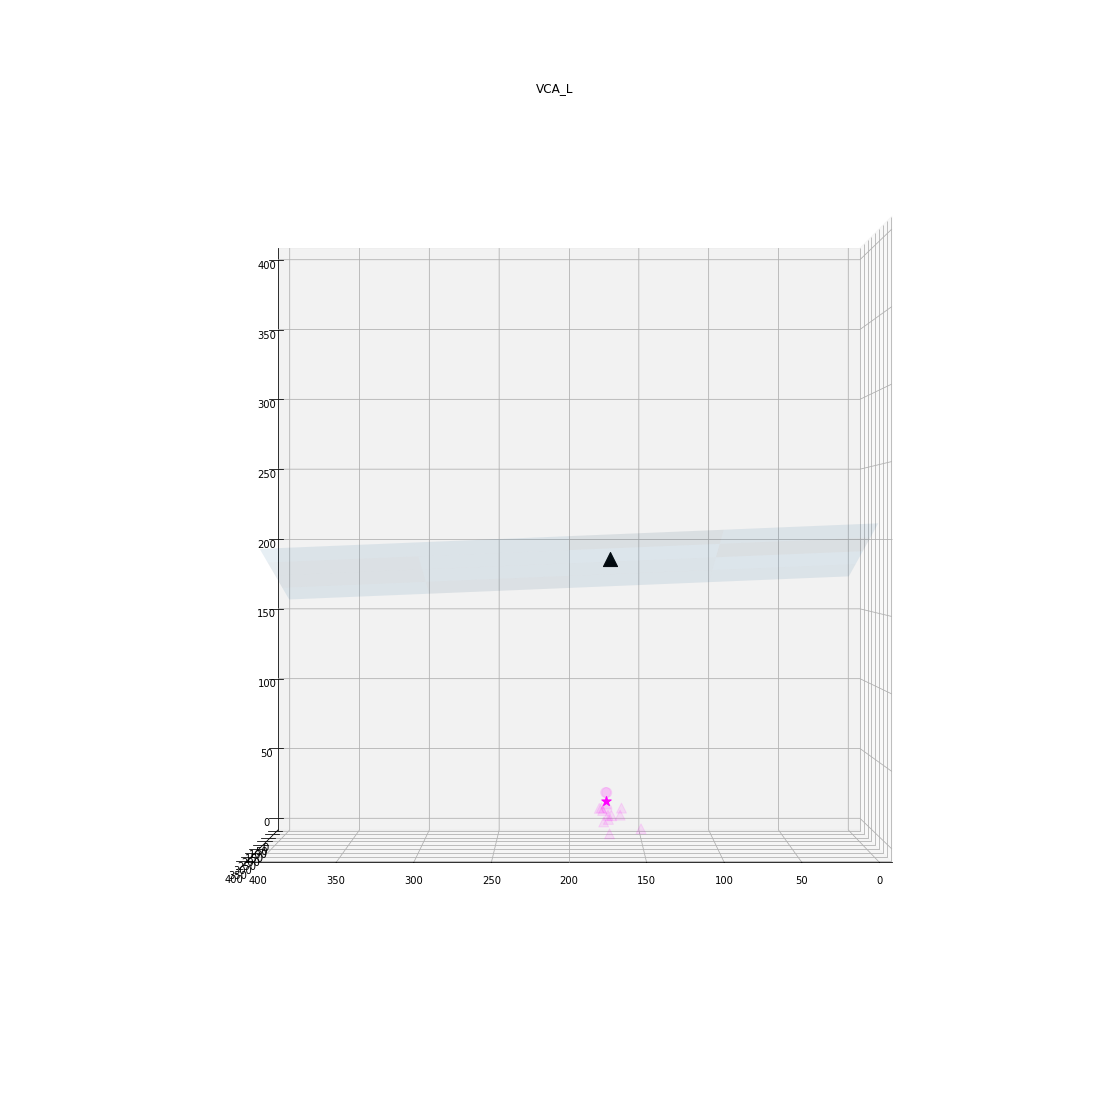

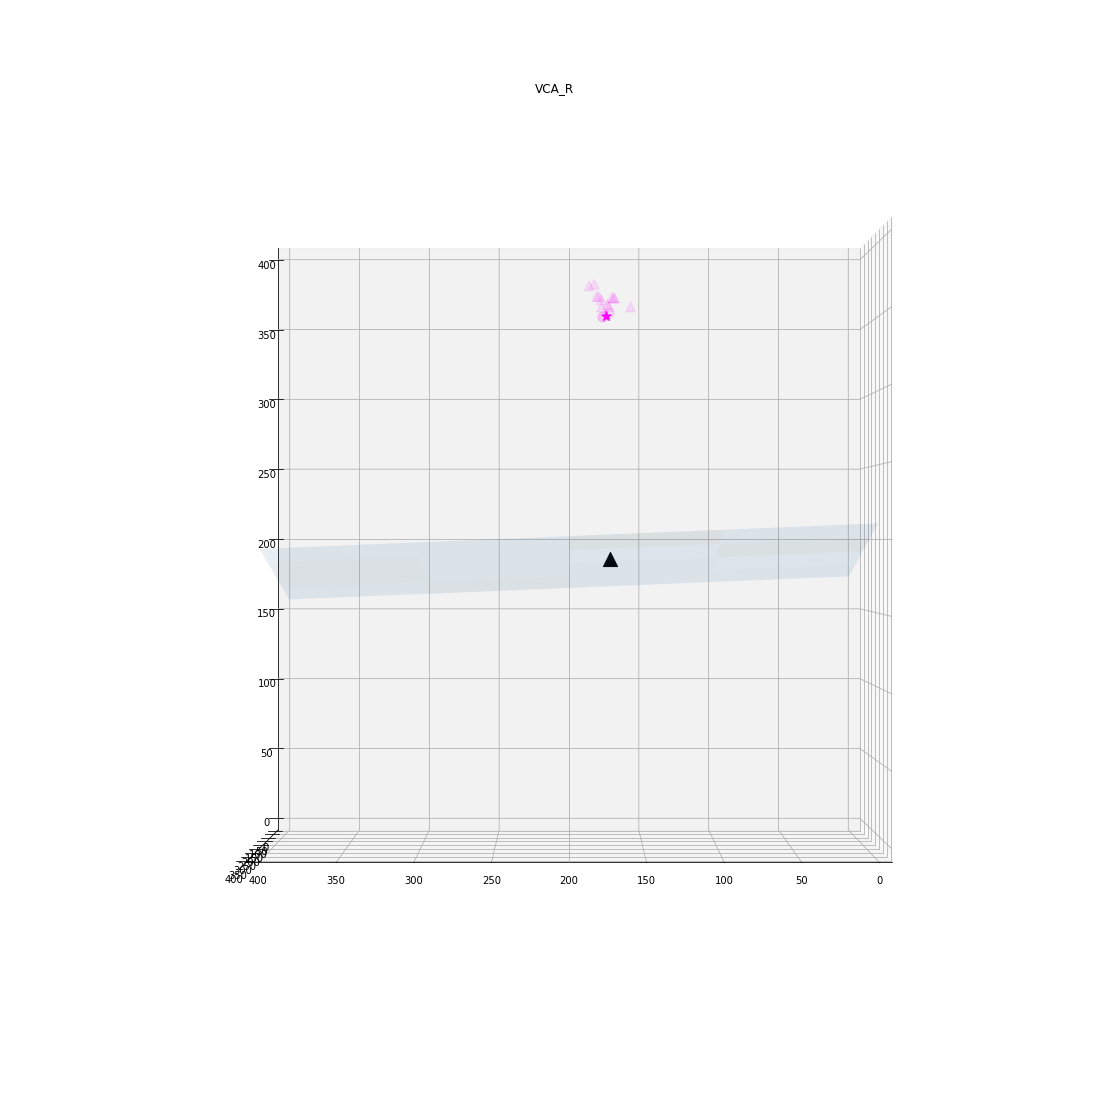

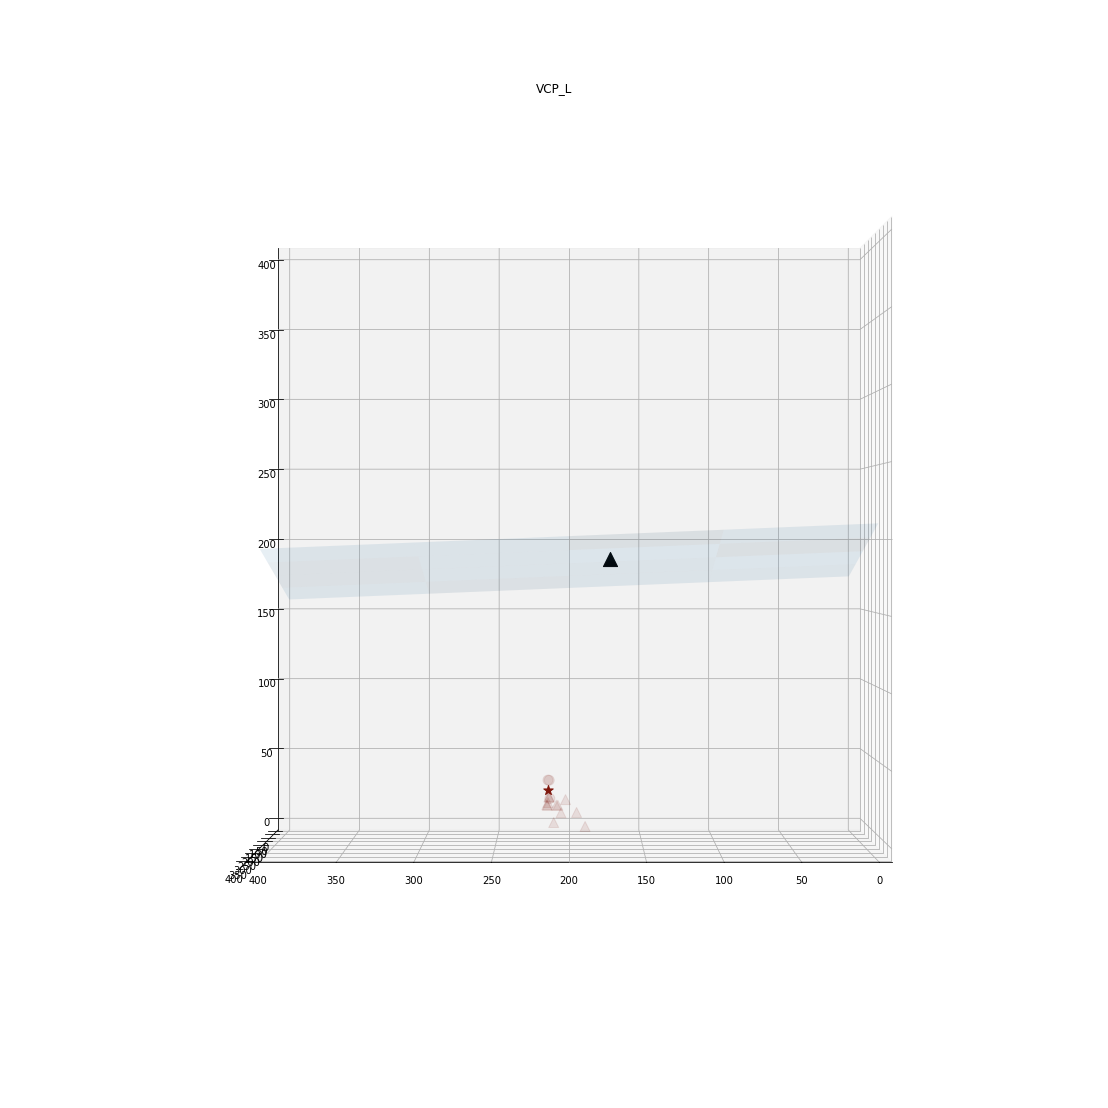

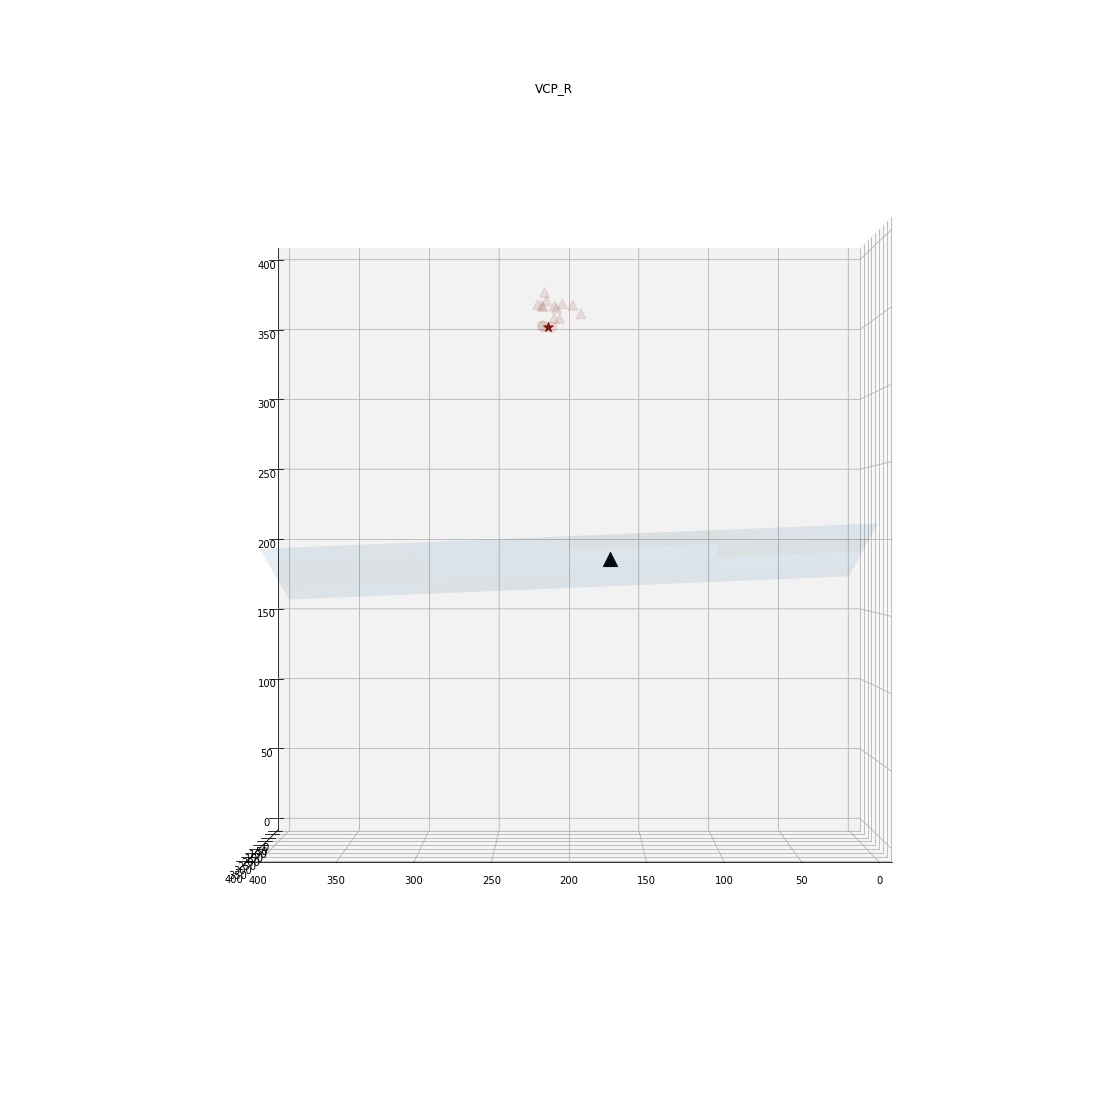

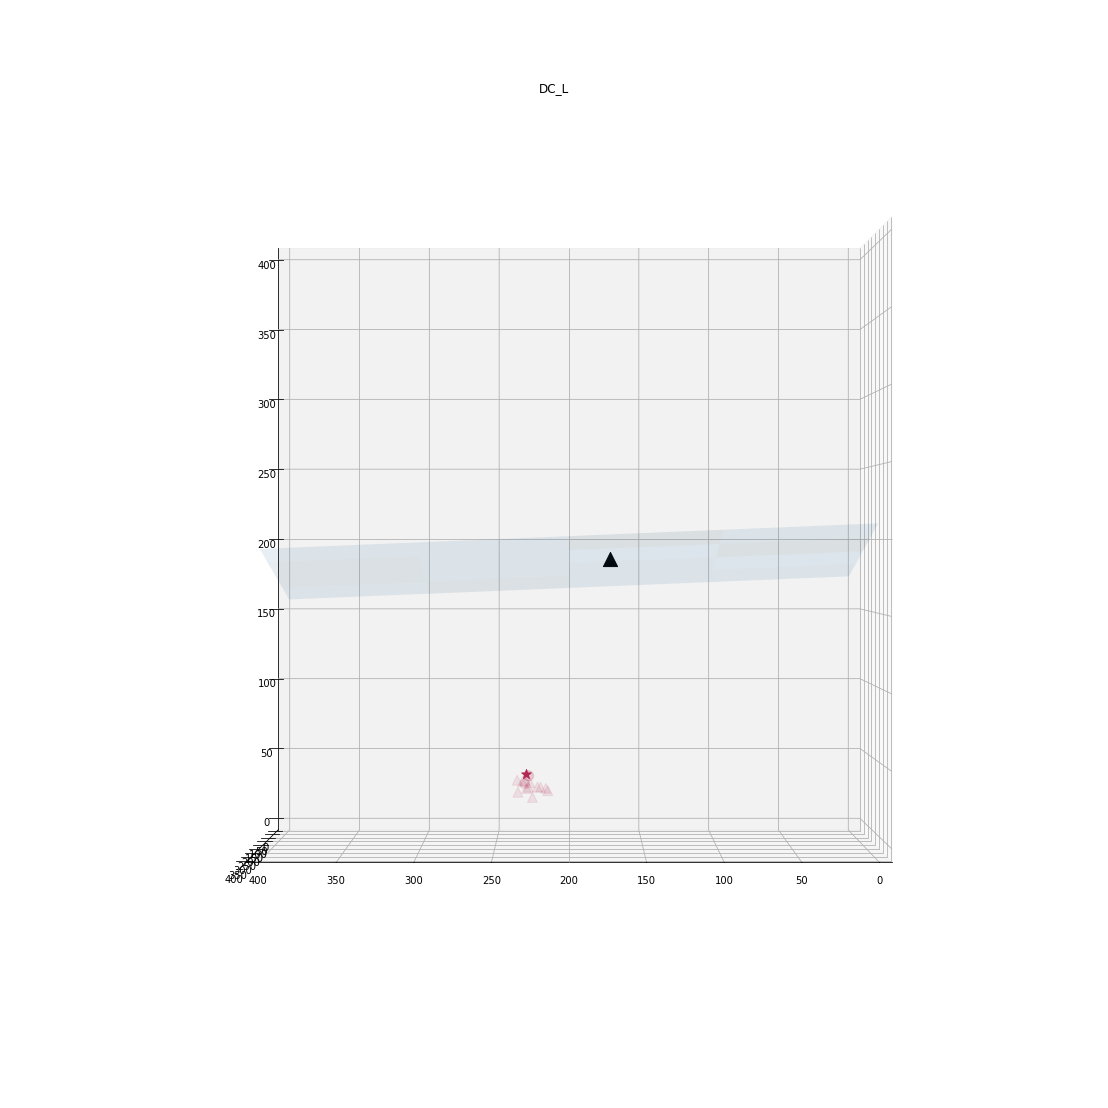

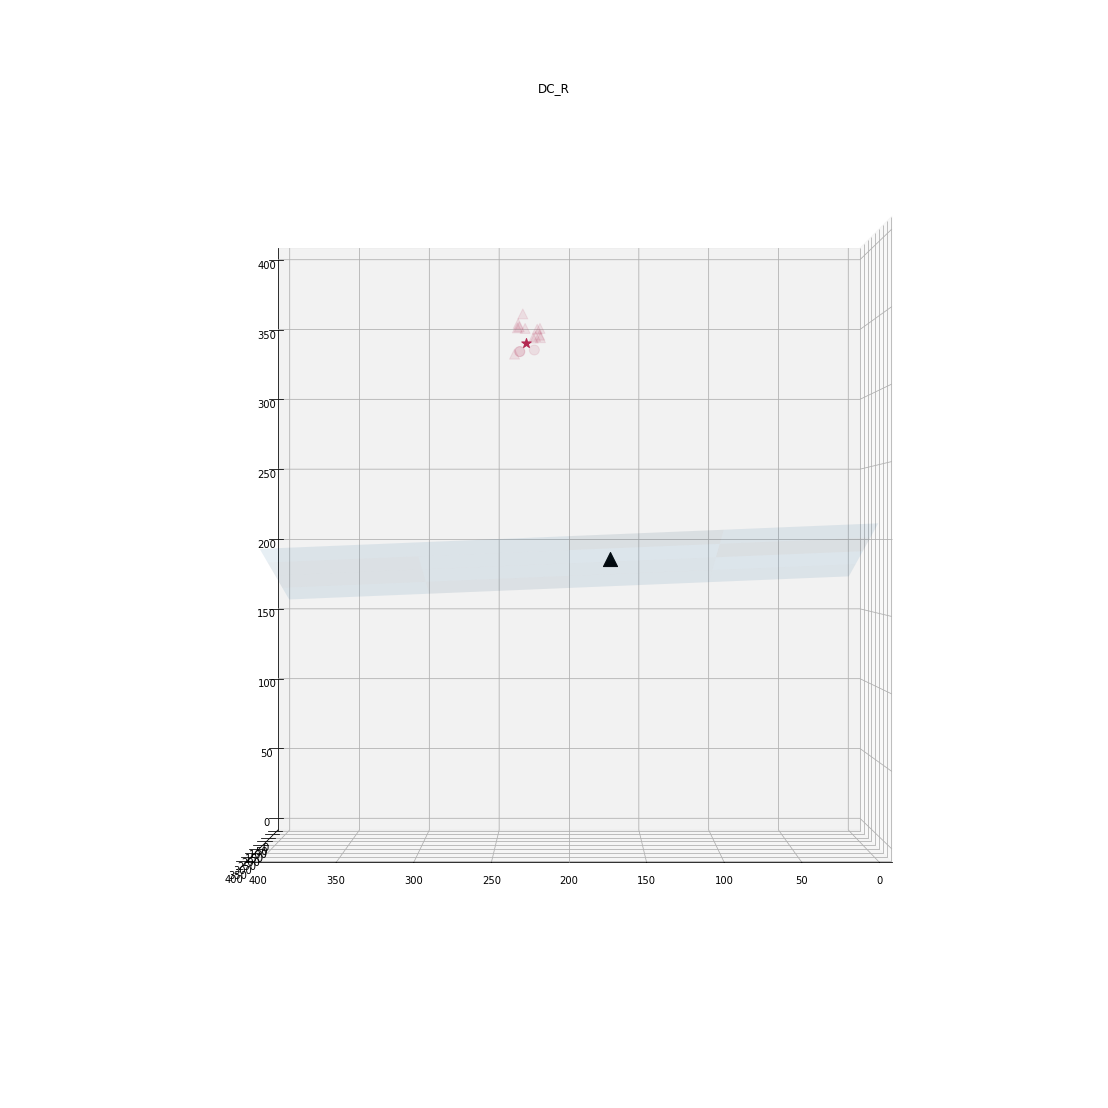

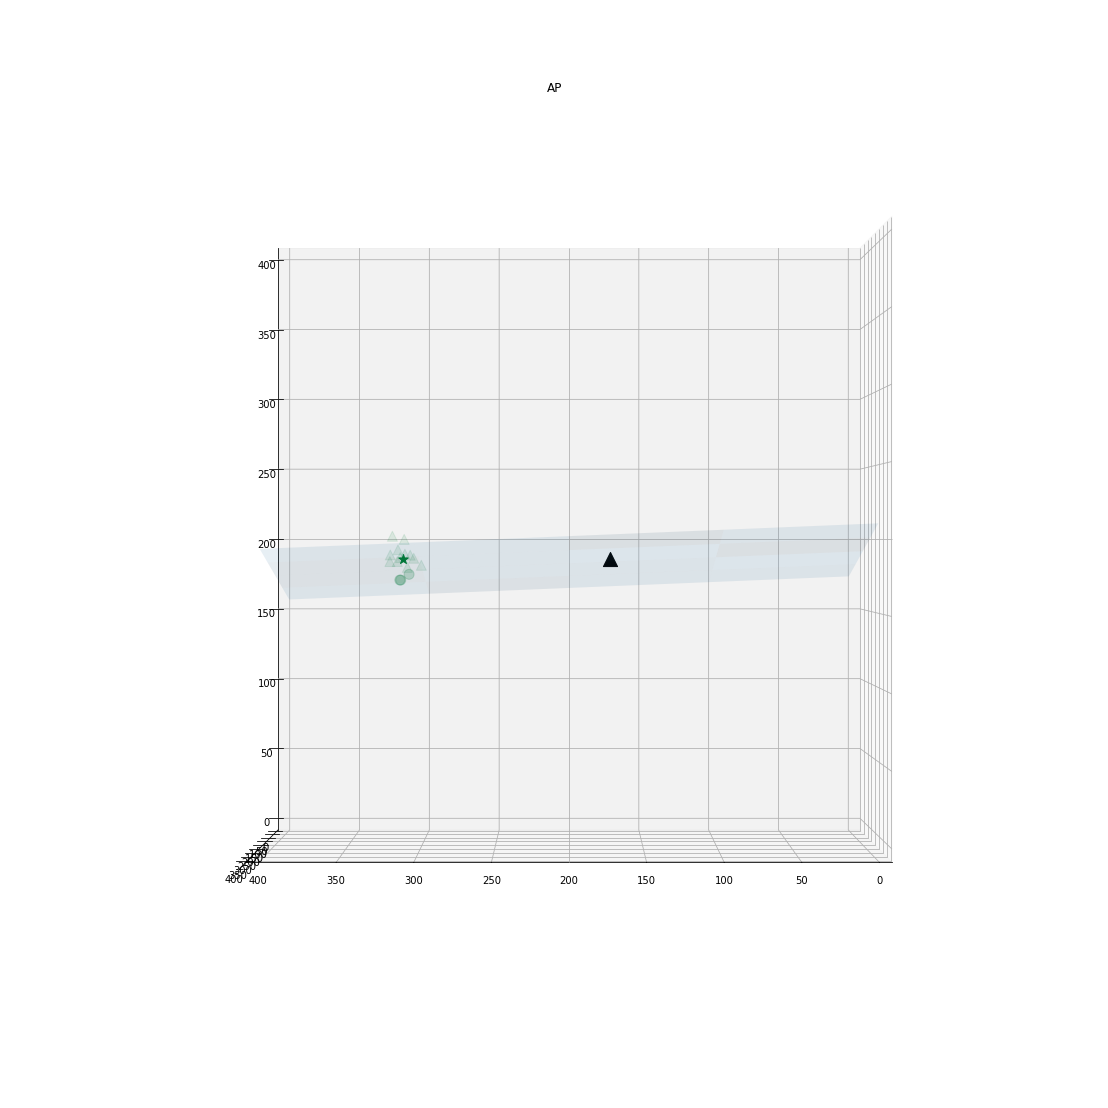

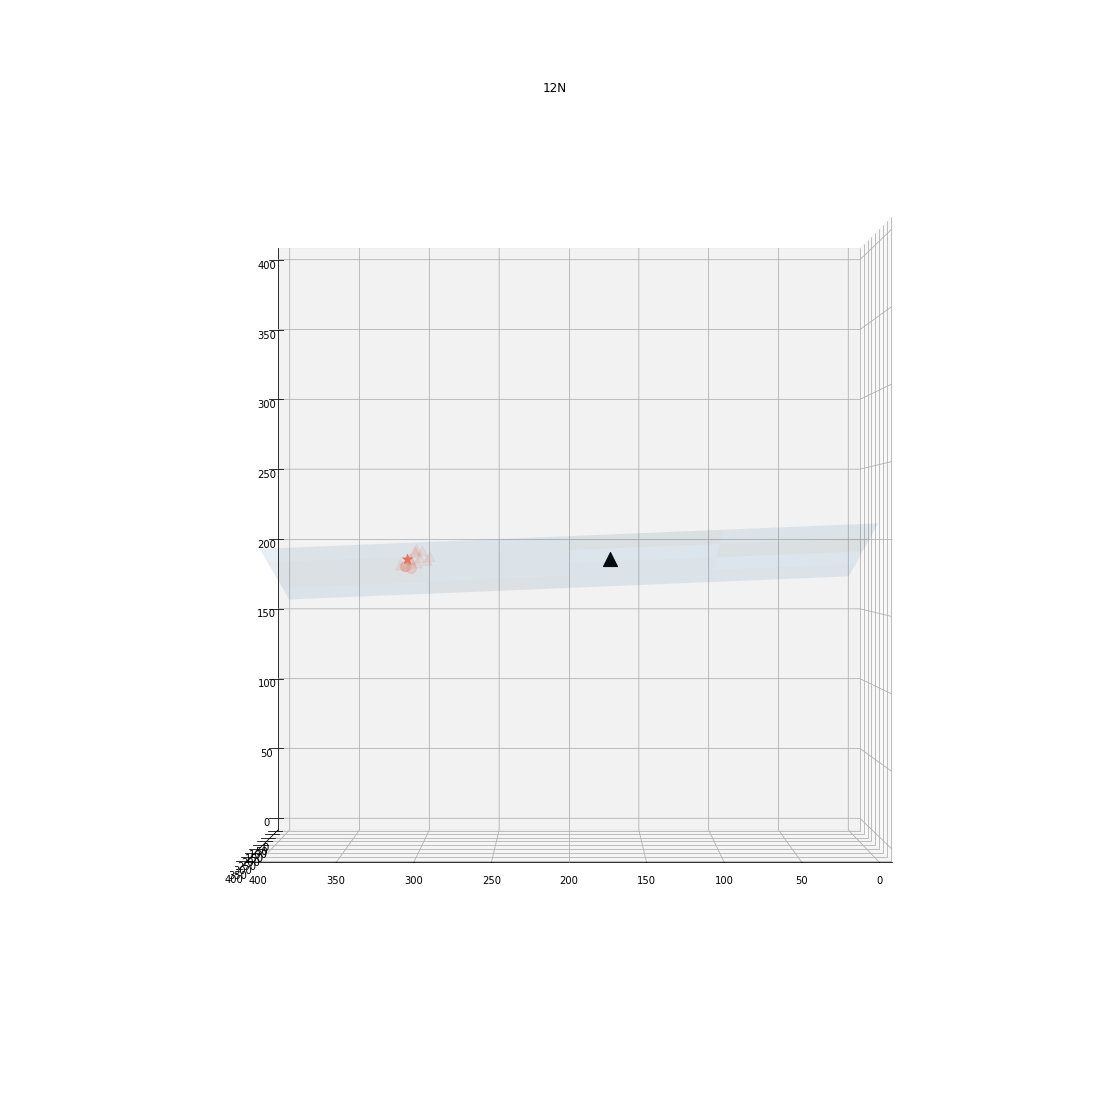

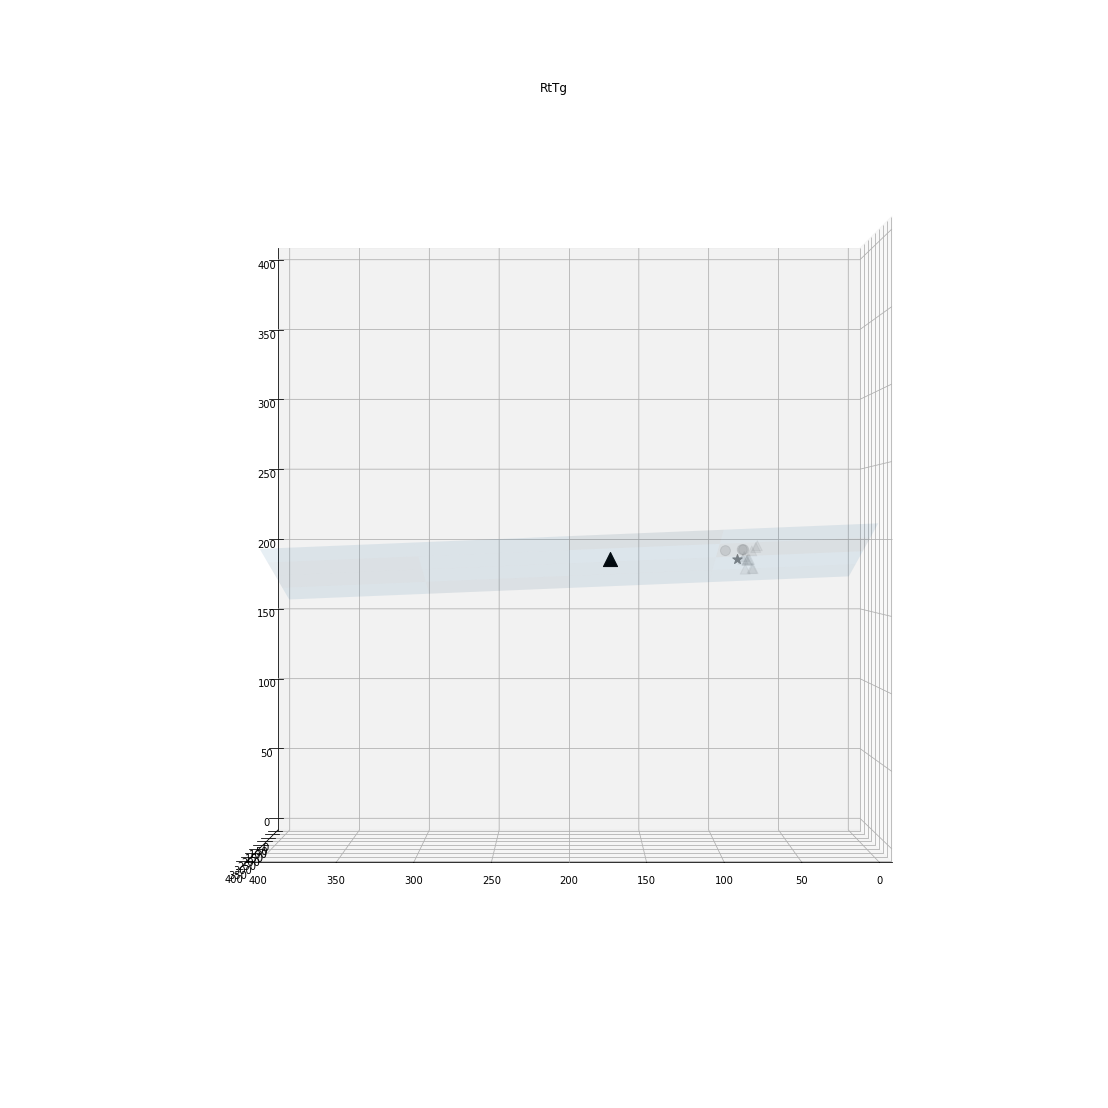

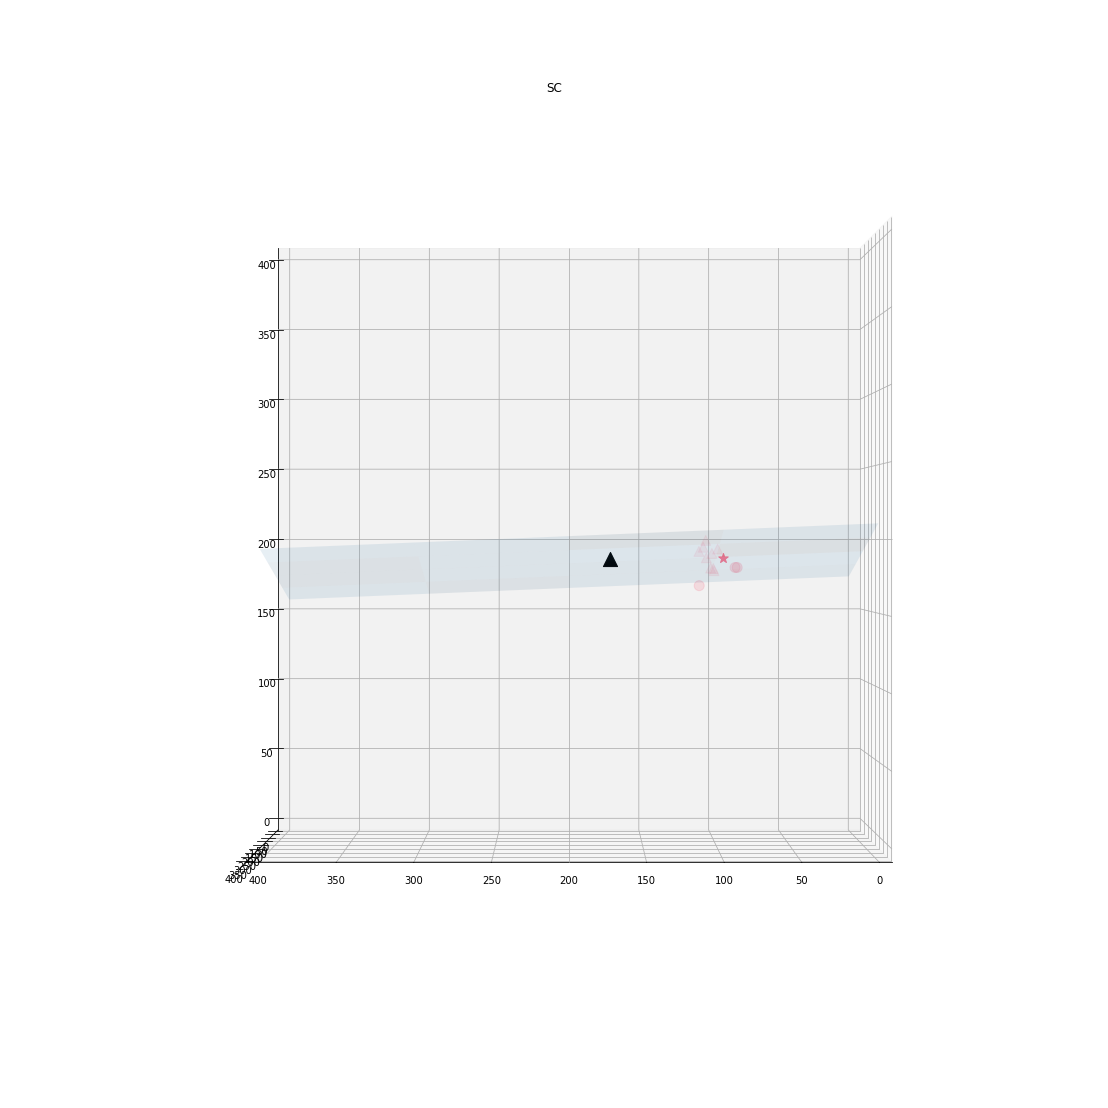

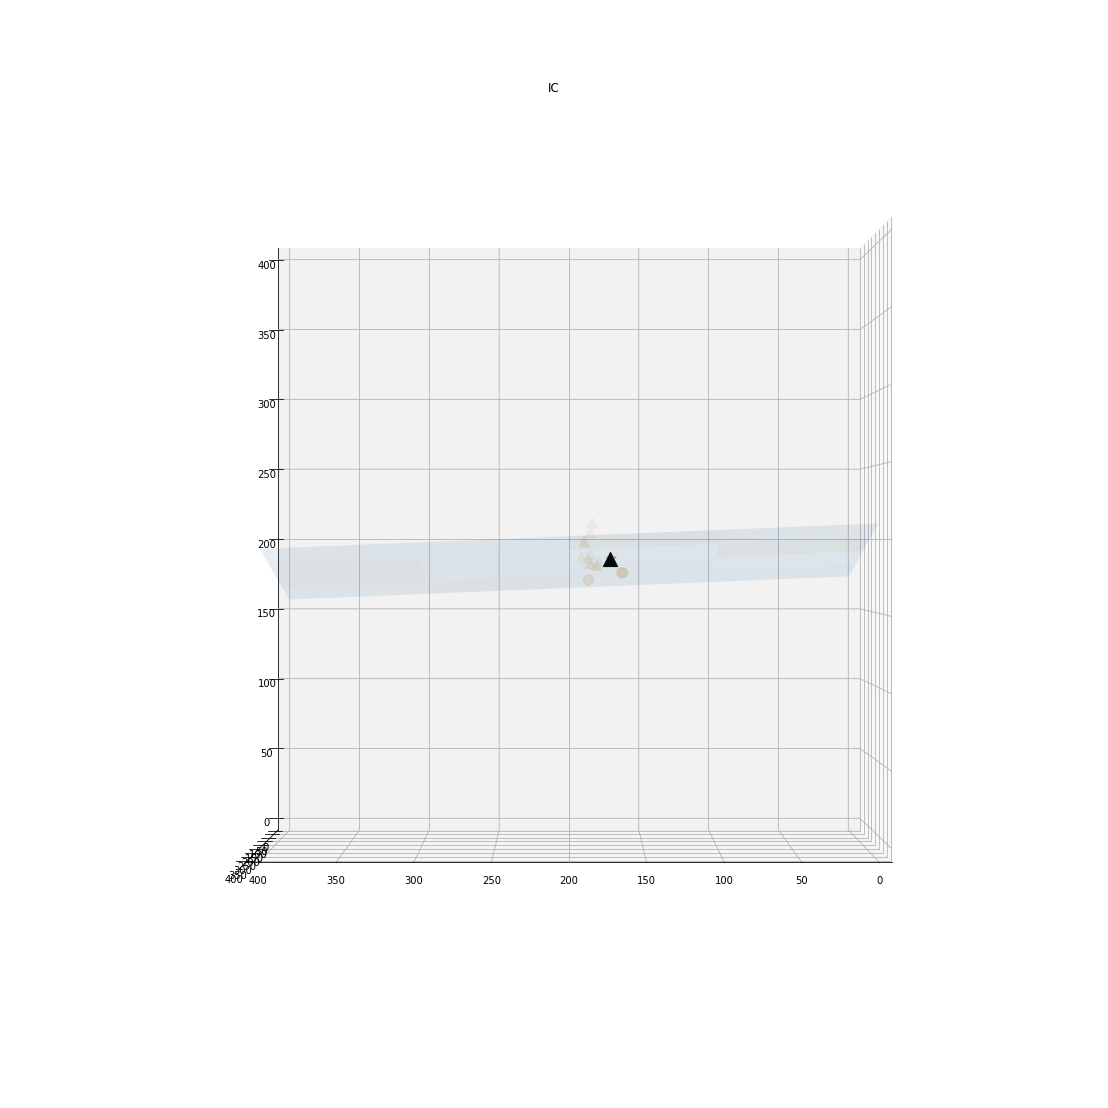

In [117]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

for ss in all_known_structures_sided:

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    for name_s, centroids_rel2fixed in instance_centroids_rel2fixed.iteritems():
        if name_s == ss:
#         if convert_to_original_name(name_s) == ss:
#         if True:
            centroids = np.array(centroids_rel2fixed)
            ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
                       color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
                       marker='o', s=100, alpha=.1)

            c = canonical_locations_rel2fixed[name_s]
            ax.scatter(c[0], c[1], c[2], 
                       color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., marker='*', s=100)

    #     # Plot uncerntainty ellipsoids
    #     u = np.linspace(0.0, 2.0 * np.pi, 100)
    #     v = np.linspace(0.0, np.pi, 100)
    #     x = radii_allStructures[name_s][0] * np.outer(np.cos(u), np.sin(v))
    #     y = radii_allStructures[name_s][1] * np.outer(np.sin(u), np.sin(v))
    #     z = radii_allStructures[name_s][2] * np.outer(np.ones_like(u), np.cos(v))
    #     for i in range(len(u)):
    #         for j in range(len(v)):
    #             [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], ellipsoid_matrix_allStructures[name_s]) + c

    #     ax.plot_surface(x, y, z, color='b')
    #     ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)

    ax.scatter(canonical_centroid_rel2fixed[0], canonical_centroid_rel2fixed[1], canonical_centroid_rel2fixed[2], 
               color=(0,0,0), marker='^', s=200)

    # Plot mid-sagittal plane
    ax.plot_surface(canonical_midplane_xx, canonical_midplane_yy, canonical_midplane_z, alpha=.1)

    #######################################################

    for name_s, centroids_rel2atlas in adjusted_structure_centroids_rel2atlas.iteritems():   
        if name_s == ss:
#         if convert_to_original_name(name_s) == ss:
#         if True:
            centroids = np.array([c for st, c in centroids_rel2atlas.iteritems()])
            ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
                       color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
                       marker='^', s=100, alpha=.1)

    ##########################################################

    # ax.set_xlabel('X Label')
    # ax.set_ylabel('Y Label')
    # ax.set_zlabel('Z Label')
    # ax.set_axis_off()
    ax.set_xlim3d([0, 400]);
    ax.set_ylim3d([0, 400]);
    ax.set_zlim3d([0, 400]);
    # ax.view_init(azim = 90 + 20,elev = 0 - 20)
    ax.view_init(azim = 90,elev = 0)
    ax.set_aspect(1.0)
    plt.legend()
    plt.title(ss);
    plt.show()

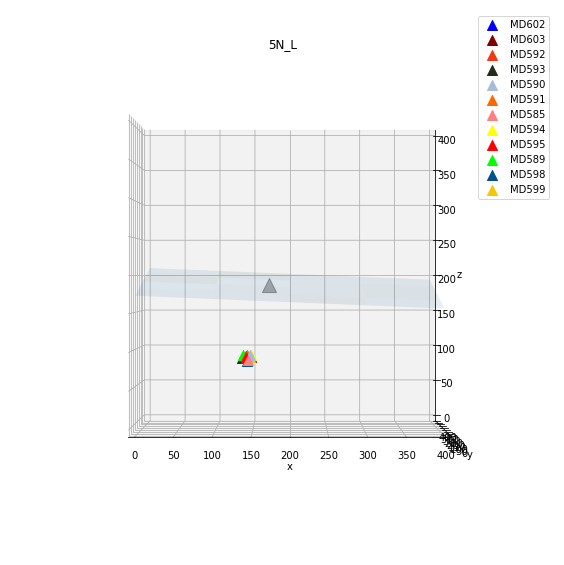

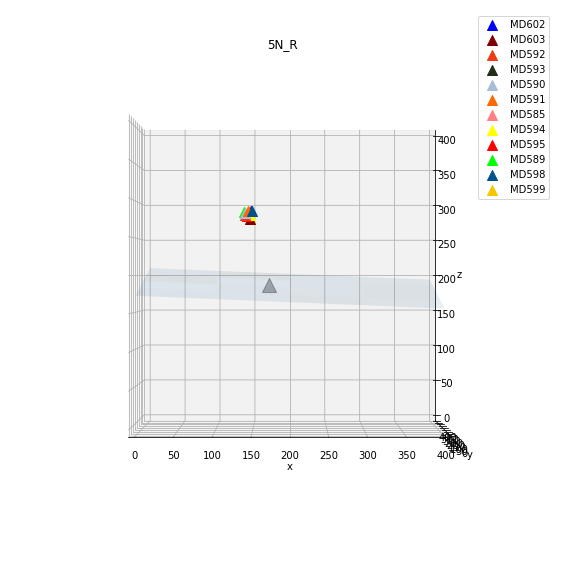

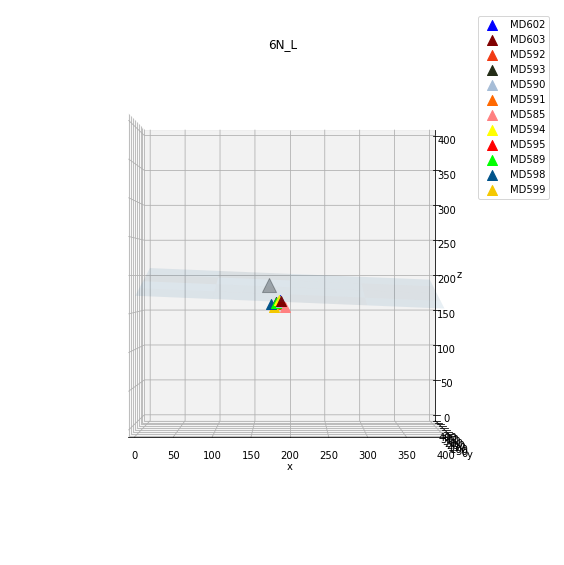

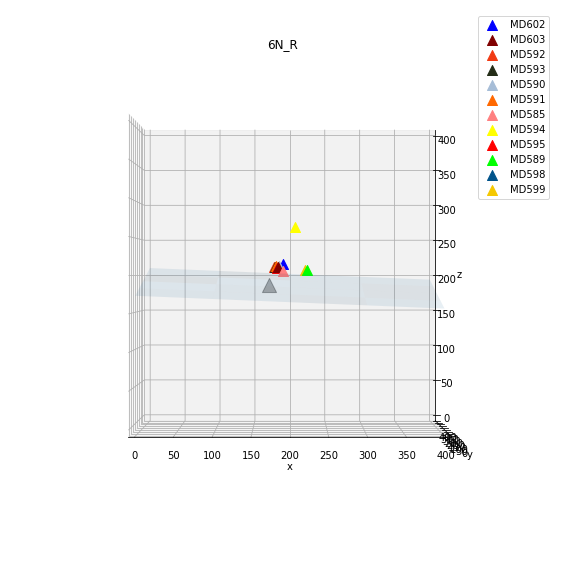

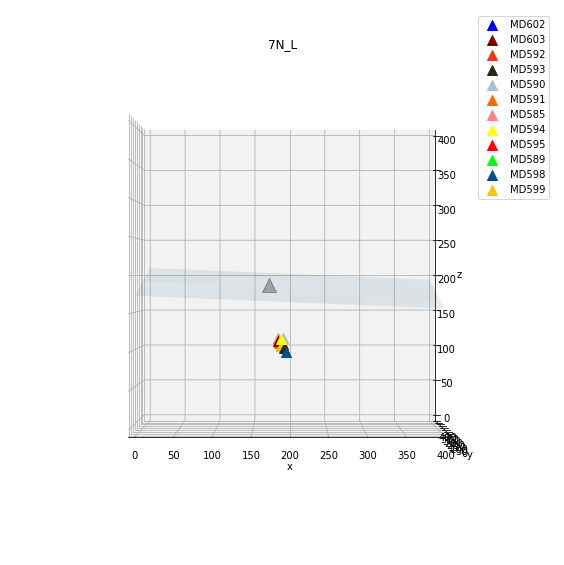

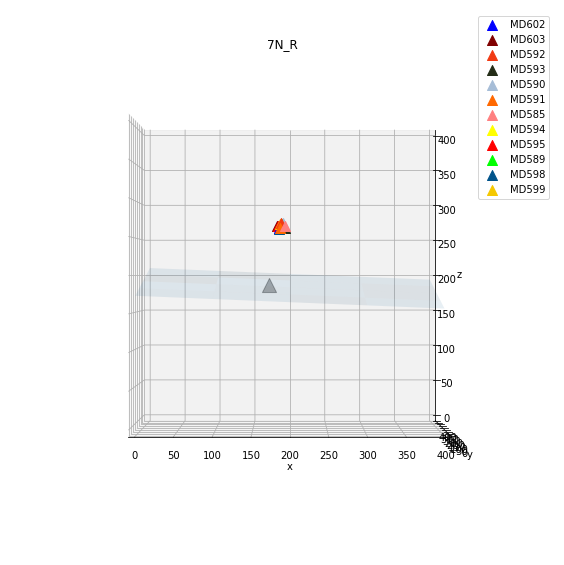

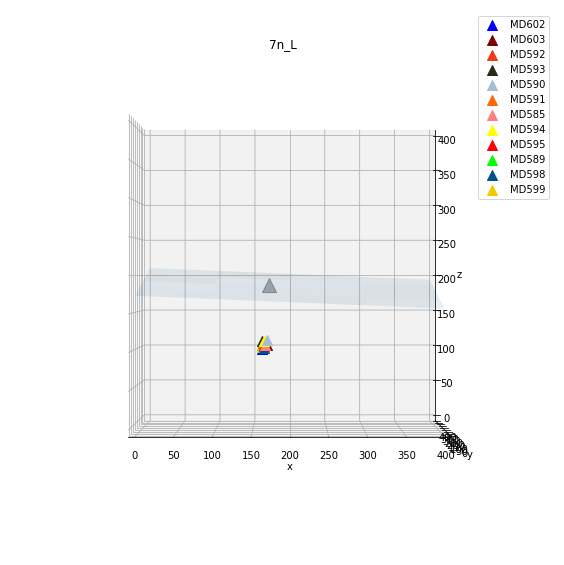

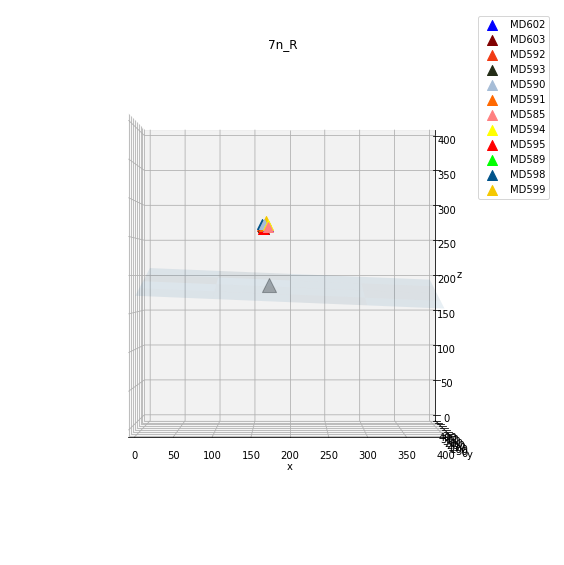

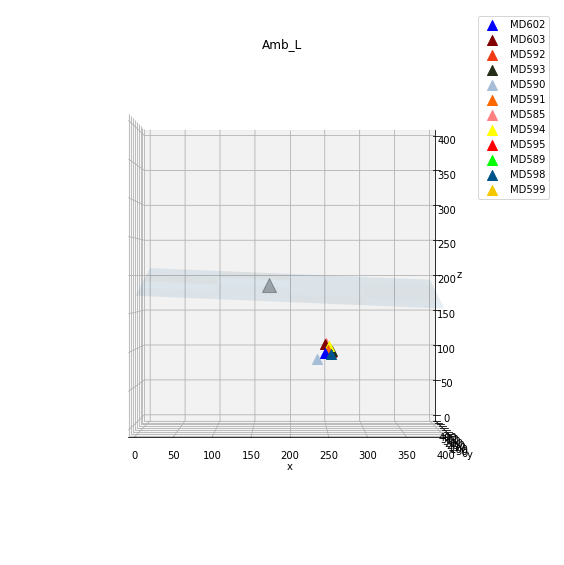

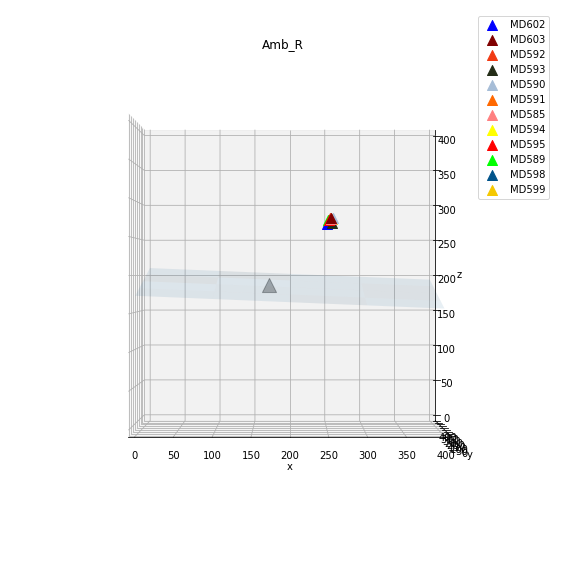

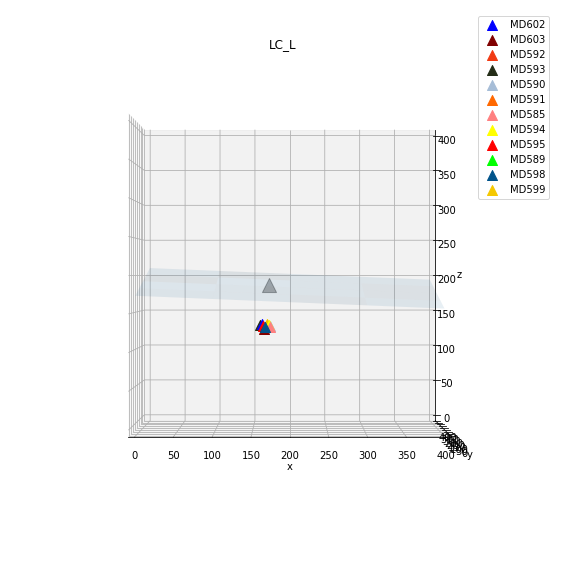

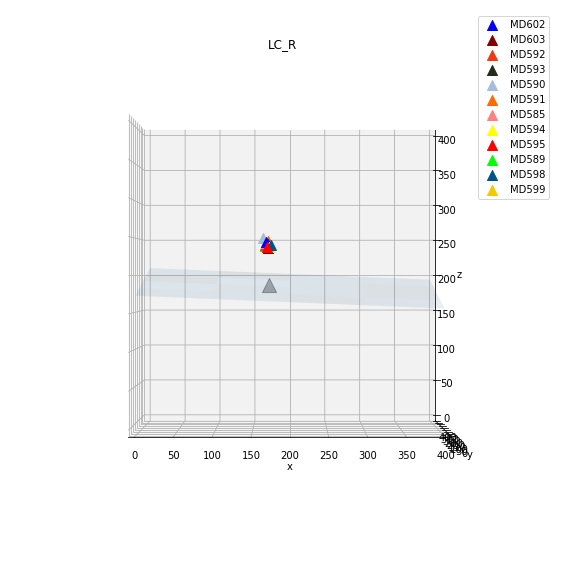

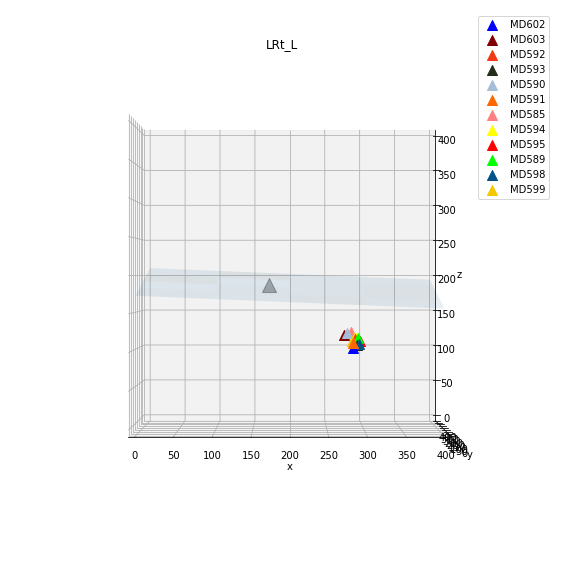

KeyboardInterrupt: 

In [126]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

for ss in all_known_structures_sided:

    fig = plt.figure(figsize=(10, 10));
    ax = fig.add_subplot(111, projection='3d')
    
    c = canonical_locations_rel2fixed[ss]
    ax.scatter(c[0], c[1], c[2], 
               color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., marker='*', s=100)

#     for name_s, centroids_rel2fixed in instance_centroids_rel2fixed.iteritems():
#         if name_s == ss:
# #         if convert_to_original_name(name_s) == ss:
# #         if True:
#             centroids = np.array(centroids_rel2fixed)
#             ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
#                        color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
#                        marker='o', s=100, alpha=.1)

#             c = canonical_locations_rel2fixed[name_s]
#             ax.scatter(c[0], c[1], c[2], 
#                        color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., marker='*', s=100)

#     #     # Plot uncerntainty ellipsoids
#     #     u = np.linspace(0.0, 2.0 * np.pi, 100)
#     #     v = np.linspace(0.0, np.pi, 100)
#     #     x = radii_allStructures[name_s][0] * np.outer(np.cos(u), np.sin(v))
#     #     y = radii_allStructures[name_s][1] * np.outer(np.sin(u), np.sin(v))
#     #     z = radii_allStructures[name_s][2] * np.outer(np.ones_like(u), np.cos(v))
#     #     for i in range(len(u)):
#     #         for j in range(len(v)):
#     #             [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], ellipsoid_matrix_allStructures[name_s]) + c

#     #     ax.plot_surface(x, y, z, color='b')
#     #     ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)

#     ax.scatter(canonical_centroid_rel2fixed[0], canonical_centroid_rel2fixed[1], canonical_centroid_rel2fixed[2], 
#                color=(0,0,0), marker='^', s=200, alpha=.3)

    # Plot mid-sagittal plane
    ax.plot_surface(canonical_midplane_xx, canonical_midplane_yy, canonical_midplane_z, alpha=.1)

    #######################################################

    for name_s, centroids_rel2atlas in adjusted_structure_centroids_rel2atlas.iteritems():   
        if name_s == ss:
#         if convert_to_original_name(name_s) == ss:
#         if True:
            for st, c in centroids_rel2atlas.iteritems():
                ax.scatter(c[0], c[1], c[2], 
                       color=np.array(stack_to_color[st])/255., 
                       marker='^', s=100, alpha=1, label=st)

    ##########################################################

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    # ax.set_axis_off()
    ax.set_xlim3d([0, 400]);
    ax.set_ylim3d([0, 400]);
    ax.set_zlim3d([0, 400]);
    # ax.view_init(azim = 90 + 20,elev = 0 - 20)
    ax.view_init(azim = 270,elev = 0)
    ax.set_aspect(1.0)
    plt.legend()
    plt.title(ss);
    plt.show()